# Beaver Bay Complex anorthosite and diabase paleointensity result compilation

We performed a comparative experiment of IZZI modified Thellier paleoitensity experiment on the diabase and anorthosite with a group having 20 mT AF treatment after each in-field step and another group without. The lab field was 30 $\mu$T. As in this attempt for selection criteria, we are using stricter selection statistics than those suggested in Sprain (2018) which studied paleointensities recorded by the volcanics in the Midcontinent Rift that are of similar age as the Beaver bay Complex. The selection criteria are:
- MAD < 10
- $\beta < 15%$
- DANG < 5$^\circ$
- FRAC > 0.6
- SCAT = TRUE
- GAP-AMX < 0.25
- NpTRM > 2
- N Arai $\geq$ 4

In [1]:
import matplotlib
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy import stats
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## defining functions for reading columns and plotting data

In [2]:
def get_specimen_list(SAM_file_path):
    this_file = open(SAM_file_path, 'r')
    lines = this_file.readlines()
    specimen_list = list()
    for i in range (2, len(lines)):
        thisline = lines[i].split('\n')
        specimen_list.append(thisline[0])
    return specimen_list

def get_PINT_data(site_df, spec_df):
    site_list = site_df.er_site_name.tolist()
    site_int_n = site_df.site_int_n.tolist()
    site_int = site_df.site_int_uT.tolist()
    site_int_sigma_uT = site_df.site_int_sigma_uT.tolist()
    spec_int_uT = spec_df.specimen_int_uT.tolist()
    spec_name_list = spec_df.er_specimen_name.tolist()
    
    return site_list, site_int_n, site_int, site_int_sigma_uT, spec_int_uT, spec_name_list

def get_percent_removed(spec_file_path):
    this_file = open(spec_file_path, 'r')
    lines = this_file.readlines()[2:]
    step_list = list()
    moment_list = list()
    for i in range(len(lines)):
        step_list.append(str(lines[i][0:6]))
        moment_list.append(float(lines[i][31:39]))
    
#     print(step_list)
#     print(moment_list)
    NRM_moment = moment_list[step_list.index('NRM   ')]
    min_moment = min(moment_list)
    
    return 1-min_moment/NRM_moment


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)

def plot_PINT(site_list, site_int_n, site_int, site_int_sigma_uT, spec_int_uT, spec_name_list, AF_spec_list=[], plot_weighted_mean = True, figsize=(14,8)):
    
    
    site_mean_color = 'black'
    site_std_color = 'grey'
    
    grand_mean_color = 'orange'
    grand_std_color = 'orange'
    weighted_mean_color = 'orange'
    
    current_site = 1
    current_spec = 0
    
    fig, ax = plt.subplots(figsize = figsize)
    
    # first lets plot the site mean and sigma
    for i in range(len(site_list)):
        ax.plot([current_site, current_site + site_int_n[i] - 1], [site_int[i], site_int[i]], color = site_mean_color)
        
        rectangle = matplotlib.patches.Rectangle((current_site, site_int[i]-site_int_sigma_uT[i]), site_int_n[i] - 1, 2*site_int_sigma_uT[i], color = site_std_color, alpha = 0.3)
        
        ax.add_patch(rectangle)
        
        ax.text(current_site + site_int_n[i]/2, site_int[i] + site_int_sigma_uT[i] + 2.5,
                 site_list[i] + '\n' + '%.2f' % site_int[i] + '$\pm$' + '%.2f' % site_int_sigma_uT[i] +' $\mu$T' , size='10',horizontalalignment='center', verticalalignment='bottom', multialignment='center')
        
        # now lets put in little squares of specimen data into site mean plot
        for j in range(site_int_n[i]):
            if spec_name_list[current_spec + j] in AF_spec_list:
                ax.scatter(current_site + j, spec_int_uT[current_spec + j], marker = 's', s = 50, color = 'lightcoral', zorder = 100)
            else:
                ax.scatter(current_site + j, spec_int_uT[current_spec + j], marker = 's', s = 50, color = 'dodgerblue', zorder = 100)
        current_spec = current_spec + site_int_n[i]
        current_site = current_site + site_int_n[i] + 1
        
    # now lets try to plot the grand mean of all sites
    grand_mean = np.mean(site_int)
    grand_std = np.std(site_int)
    print(grand_mean, grand_std)
    
    inverse_int_sigma = [1/i for i in site_int_sigma_uT]
    inverse_int_sigma_sum = sum(inverse_int_sigma)
    inverse_int_sigma_weight = [i/inverse_int_sigma_sum for i in inverse_int_sigma]

    weighted_mean = weighted_avg_and_std(site_int, weights = inverse_int_sigma_weight)[0]
    weighted_std = weighted_avg_and_std(site_int, weights = inverse_int_sigma_weight)[1]
    print(weighted_mean)
    print(weighted_std)
    
#     if plot_weighted_mean == True:
#         ax.plot([-10, len(spec_int_uT)+50], [weighted_mean, weighted_mean], linestyle = 'dashed', color = weighted_mean_color)
#         ax.fill_between([-10, len(spec_int_uT)+50], 
#                         [weighted_mean-weighted_std, weighted_mean-weighted_std], 
#                         [weighted_mean+weighted_std, weighted_mean+weighted_std], 
#                         color = grand_std_color, alpha = 0.1)
# #         ax.plot([-10, len(spec_int_uT)+50], [weighted_mean+weighted_std, weighted_mean+weighted_std], linestyle = 'dashed', color = grand_std_color, alpha = 0.5)
#         return fig, ax, weighted_mean, weighted_std 
#     else:
         
#         ax.plot([-10, len(spec_int_uT)+50], [grand_mean, grand_mean], linestyle = 'dashed', color = grand_mean_color)
#         ax.fill_between([-10, len(spec_int_uT)+50], 
#                         [grand_mean-grand_std, grand_mean-grand_std], 
#                         [grand_mean+grand_std, grand_mean+grand_std], 
#                         color = grand_std_color, alpha = 0.1)
        
    return fig, ax, grand_mean, grand_std
#     grand_mean_rectangle = matplotlib.patches.Rectangle((-10, grand_mean-grand_std), len(spec_int_uT)+50, 2*grand_std, color = 'lightgreen', alpha = 0.4)
#     plt.gca().add_patch(grand_mean_rectangle)
    
    # now lets make some legend

## Loading magnetometer file to calculate the percentage of NRM removed for each specimen

In [3]:
All_AX_spec_list = list()
All_AX_spec_list.extend(get_specimen_list('../data/IZZI/All_AX_PINT/AX_AF_PINT.sam'))
All_AX_spec_list.extend(get_specimen_list('../data/IZZI/All_AX_PINT/AX_NRM_PINT.sam'))

All_AX_spec_list.sort()

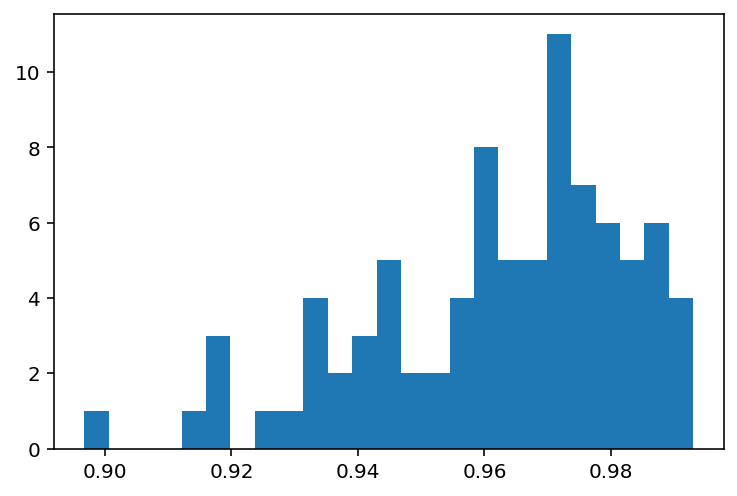

In [4]:
percent_remove_list = list()
for i in range(len(All_AX_spec_list)):
    percent_remove_list.append(get_percent_removed('../data/IZZI/All_AX_PINT/' + All_AX_spec_list[i]))

plt.hist(percent_remove_list, bins=25)
plt.show()

## Loading MagIC data file

In [5]:
# Loading files
AX_all_PINT_site = pd.read_csv('../data/IZZI/All_AX_PINT/thellier_interpreter/thellier_interpreter_STDEV-OPT_sites.txt', sep = '\t', header = 4)
AX_all_PINT_specimen = pd.read_csv('../data/IZZI/All_AX_PINT/thellier_interpreter/thellier_interpreter_STDEV-OPT_specimens.txt', sep = '\t', header = 1)

# try dropping out AX6
# AX_all_PINT_site = AX_all_PINT_site.drop(AX_all_PINT_site[AX_all_PINT_site['er_site_name'].str.contains('AX6')].index)
# AX_all_PINT_specimen = AX_all_PINT_specimen.drop(AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX6')].index)
BD_all_PINT_site = pd.read_csv('../data/IZZI/All_BD_PINT//thellier_interpreter/thellier_interpreter_STDEV-OPT_sites.txt', sep = '\t', header = 4)
BD_all_PINT_specimen = pd.read_csv('../data/IZZI/All_BD_PINT/thellier_interpreter/thellier_interpreter_STDEV-OPT_specimens.txt', sep = '\t', header = 1)

In [6]:
# get the lists of  AF pretreatment specimens and those without
AX_AF_spec_list = get_specimen_list('../data/IZZI/AX_AF_PINT/AX_AF_PINT.sam')
BD_AF_spec_list = get_specimen_list('../data/IZZI/BD_AF_PINT/BD_AF_PINT_old.sam')

All_AF_spec_list = list()
All_AF_spec_list.extend(AX_AF_spec_list)
All_AF_spec_list.extend(BD_AF_spec_list)

## sort data files so that they are ordered by site locations and by ascending paleointensities

In [7]:
AX_all_PINT_site.er_site_name = pd.Categorical(AX_all_PINT_site.er_site_name, ['AX6', 'AX8', 'AX10', 'AX12' ,'AX16', 'AX11', 'AX13'])
AX_all_PINT_site = AX_all_PINT_site.sort_values('er_site_name')
AX_all_PINT_site.head()

,er_site_name,site_int_n,site_int_uT,site_int_sigma_uT,site_int_sigma_perc,site_int_min_uT,site_int_min_sigma_uT,site_int_max_uT,site_int_max_sigma_uT,site_int_interval_uT,site_int_interval_perc,Warning,Unnamed: 12,Unnamed: 13
0,AX6,3,30.33,15.17,50.01,28.81,16.35,32.92,19.548,4.11,13.55,No anisotropy corrections; No cooling rate co...,NaN,NaN
1,AX8,3,52.40,12.15,23.18,51.41,13.06,54.24,15.151,2.83,5.40,No anisotropy corrections; No cooling rate co...,NaN,NaN
2,AX10,3,46.82,1.10,2.35,45.15,3.81,60.73,21.758,15.59,33.29,No anisotropy corrections; No cooling rate co...,NaN,NaN
4,AX12,6,38.10,5.85,15.37,37.19,6.32,40.96,8.724,3.76,9.87,No anisotropy corrections; No cooling rate co...,NaN,NaN
6,AX16,11,44.15,5.08,11.50,41.37,6.40,50.13,12.905,8.75,19.83,No anisotropy corrections; No cooling rate co...,NaN,NaN


In [8]:
AX_all_PINT_specimen.er_sample_name = pd.Categorical(AX_all_PINT_specimen.er_sample_name, ['AX6', 'AX8', 'AX10', 'AX12' ,'AX16', 'AX11', 'AX13'])
AX_all_PINT_specimen = AX_all_PINT_specimen.sort_values(['er_sample_name', 'specimen_int_uT'])
AX_all_PINT_specimen.head(5)

,er_sample_name,er_specimen_name,specimen_int_uT,measurement_step_min,measurement_step_min.1,specimen_lab_field_dc,Anisotropy_correction_factor,NLT_correction_factor,Cooling_rate_correction_factor,specimen_int_n,specimen_frac,specimen_int_ptrm_n,specimen_b_beta,specimen_gmax,specimen_int_mad,specimen_int_dang,specimen_scat
35,AX6,AX6-2a,18.25,400,585,30,1.0,-,-,18.0,0.70,10.0,0.04,0.12,3.44,3.43,t
36,AX6,AX6-3a,25.39,400,585,30,1.0,-,-,18.0,0.76,10.0,0.04,0.10,4.28,2.88,t
34,AX6,AX6-1a,47.36,475,585,30,1.0,-,-,15.0,0.60,10.0,0.02,0.16,2.92,1.67,t
39,AX8,AX8-3a,41.30,400,580,30,1.0,-,-,17.0,0.75,9.0,0.03,0.14,4.38,2.22,t
38,AX8,AX8-2a,50.51,400,580,30,1.0,-,-,17.0,0.63,9.0,0.04,0.16,3.19,1.29,t


In [9]:
BD_all_PINT_specimen = BD_all_PINT_specimen.sort_values('specimen_int_uT')
BD_all_PINT_specimen

,er_sample_name,er_specimen_name,specimen_int_uT,measurement_step_min,measurement_step_min.1,specimen_lab_field_dc,Anisotropy_correction_factor,NLT_correction_factor,Cooling_rate_correction_factor,specimen_int_n,specimen_frac,specimen_int_ptrm_n,specimen_b_beta,specimen_gmax,specimen_int_mad,specimen_int_dang,specimen_scat


## Get paleolatitude list from directional results 

In [10]:
AX_BD_site_path = '../data/Demag/sites.txt'
AX_BD_site_data = pd.read_csv(AX_BD_site_path, sep='\t',header=1)

In [11]:
# calculate paleolatitude from the inclination data
AX_BD_site_data['paleolatitude'] = round(pmag.plat(AX_BD_site_data['dir_inc']),2)

# filter out BD14 and BD16 likely lightning zapped sites
AX_BD_site_data = AX_BD_site_data.drop(AX_BD_site_data[AX_BD_site_data['site'] == 'BD14'].index)
AX_BD_site_data = AX_BD_site_data.drop(AX_BD_site_data[AX_BD_site_data['site'] == 'BD16'].index)

# filter for the mid temp and mid coercivity components after tilt correction 
AX_BD_site_mct_tc = AX_BD_site_data[(AX_BD_site_data['dir_comp_name'].isin(['mc','mt'])) & (AX_BD_site_data['dir_tilt_correction'] == 100)]
AX_site_mct_tc = AX_BD_site_mct_tc[AX_BD_site_mct_tc['site'].str.startswith('AX')]
BD_site_mct_tc = AX_BD_site_mct_tc[AX_BD_site_mct_tc['site'].str.startswith('BD')]

AX_plat = AX_site_mct_tc[['site', 'paleolatitude']].set_index('site')
BD_plat = BD_site_mct_tc[['site', 'paleolatitude']].set_index('site')

AX_plat = pd.Series(data=AX_plat['paleolatitude'], index=AX_plat.index)
BD_plat = pd.Series(data=BD_plat['paleolatitude'], index=BD_plat.index)

In [12]:
AX_site_mct_tc[['site', 'dir_dec', 'dir_inc', 'dir_k', 'dir_alpha95']]

,site,dir_dec,dir_inc,dir_k,dir_alpha95
1,AX1,288.8,54.9,539.0,2.4
3,AX10,278.9,36.6,356.0,6.5
5,AX11,281.7,35.2,308.0,3.2
7,AX12,297.3,55.2,36.0,11.3
9,AX13,287.3,35.1,434.0,2.5
11,AX14,293.9,50.8,257.0,3.8
13,AX15,275.8,53.5,86.0,6.0
15,AX16,265.8,49.2,397.0,2.8
17,AX17,261.6,59.6,642.0,2.2
19,AX18,276.0,56.9,542.0,2.2


In [13]:
AX_site_pair_plat = [AX_site_mct_tc['site'].tolist(), AX_site_mct_tc['paleolatitude'].tolist()]
BD_site_pair_plat = [BD_site_mct_tc['site'].tolist(), BD_site_mct_tc['paleolatitude'].tolist()]

In [14]:
AX_PINT_data = get_PINT_data(AX_all_PINT_site, AX_all_PINT_specimen)
BD_PINT_data = get_PINT_data(BD_all_PINT_site, BD_all_PINT_specimen)
AX_PINT_lat = [AX_plat[i] for i in AX_PINT_data[0]]
BD_PINT_lat = [BD_plat[i] for i in BD_PINT_data[0]]

## cooling rate correction and generate data table

In [15]:
cooling_rate_correction = 1.33

## calculate VDM values (cooling rate corrected)

In [16]:
AX_vdm_list =[round(pmag.b_vdm(AX_PINT_data[2][i]/1e6/cooling_rate_correction, AX_PINT_lat[i]), 2) for i in range(len(AX_PINT_lat))]
BD_vdm_list =[round(pmag.b_vdm(BD_PINT_data[2][i]/1e6/cooling_rate_correction, BD_PINT_lat[i]), 2) for i in range(len(BD_PINT_lat))]
display(AX_vdm_list)
# display(BD_vdm_list)

[4.94896915609689e+22,
 8.439836384975164e+22,
 7.796109585301124e+22,
 5.208262158655997e+22,
 6.482355353517264e+22,
 1.2355592047677335e+23,
 1.2921000154072587e+23]

In [17]:
np.mean(AX_vdm_list)

8.307446405756623e+22

## calculate gamma values

In [18]:
AX_all_measurements = pd.read_csv('../data/IZZI/All_AX_PINT/measurements.txt', sep='\t', header=1)
AX_all_measurements = AX_all_measurements[AX_all_measurements['treat_dc_field']!=0]

AX_all_measurements_group = AX_all_measurements.groupby('specimen').apply(lambda x: x.iloc[x['sequence'].argmax()])
AX_all_measurements_group = AX_all_measurements_group.reset_index(drop=True)

In [19]:
# now let's compare the angle between the last measurement with inc=-90 which is the applied field direction

AX_all_measurements_group['gamma'] = np.abs(AX_all_measurements_group['dir_inc']+90)

In [20]:
AX_all_measurements_group.index = AX_all_measurements_group['specimen']
AX_all_measurements_group['gamma'].head()

specimen
AX1-1a    1.4
AX1-2a    1.0
AX1-3a    1.5
AX1-4a    2.3
AX1-5a    0.6
Name: gamma, dtype: float64

In [21]:
AX_inc = pd.Series(data=AX_site_mct_tc['dir_inc'].tolist(), index=AX_site_mct_tc['site'])
AX_all_PINT_specimen['specimen_int_uT'] = np.round(AX_all_PINT_specimen['specimen_int_uT']/cooling_rate_correction,2)
AX_all_PINT_specimen['dir_inc'] = [AX_inc[i] for i in AX_all_PINT_specimen['er_sample_name']]
AX_all_PINT_specimen['paleolatitude'] = [AX_plat[i] for i in AX_all_PINT_specimen['er_sample_name']]
AX_all_PINT_specimen['gamma'] = AX_all_PINT_specimen['er_specimen_name'].map(AX_all_measurements_group['gamma'])
AX_all_PINT_specimen['VDM'] = [round(pmag.b_vdm(AX_all_PINT_specimen['specimen_int_uT'].tolist()[i]/1e6, 
                                                 AX_all_PINT_specimen['paleolatitude'].tolist()[i])/1e21, 1) for i in range(AX_all_PINT_specimen.shape[0])]
AX_all_PINT_specimen_export = AX_all_PINT_specimen.drop(['specimen_lab_field_dc', 'Anisotropy_correction_factor','NLT_correction_factor', 'Cooling_rate_correction_factor'], axis = 1)
AX_all_PINT_specimen_export['specimen_scat'] = 'PASS'
AX_all_PINT_specimen_export.head()

,er_sample_name,er_specimen_name,specimen_int_uT,measurement_step_min,measurement_step_min.1,specimen_int_n,specimen_frac,specimen_int_ptrm_n,specimen_b_beta,specimen_gmax,specimen_int_mad,specimen_int_dang,specimen_scat,dir_inc,paleolatitude,gamma,VDM
35,AX6,AX6-2a,13.72,400,585,18.0,0.70,10.0,0.04,0.12,3.44,3.43,PASS,38.9,21.97,2.7,29.8
36,AX6,AX6-3a,19.09,400,585,18.0,0.76,10.0,0.04,0.10,4.28,2.88,PASS,38.9,21.97,3.2,41.4
34,AX6,AX6-1a,35.61,475,585,15.0,0.60,10.0,0.02,0.16,2.92,1.67,PASS,38.9,21.97,2.0,77.3
39,AX8,AX8-3a,31.05,400,580,17.0,0.75,9.0,0.03,0.14,4.38,2.22,PASS,40.3,22.98,11.2,66.5
38,AX8,AX8-2a,37.98,400,580,17.0,0.63,9.0,0.04,0.16,3.19,1.29,PASS,40.3,22.98,3.7,81.4


In [22]:
AX_all_PINT_specimen_export.columns

Index(['er_sample_name', 'er_specimen_name', 'specimen_int_uT',
       'measurement_step_min', 'measurement_step_min.1', 'specimen_int_n',
       'specimen_frac', 'specimen_int_ptrm_n', 'specimen_b_beta',
       'specimen_gmax', 'specimen_int_mad', 'specimen_int_dang',
       'specimen_scat', 'dir_inc', 'paleolatitude', 'gamma', 'VDM'],
      dtype='object')

In [23]:
map_site_to_region = pd.Series(index=['AX6', 'AX8', 'AX10', 'AX11', 'AX12', 'AX13', 'AX16'], 
                               data = ['Carlton Peak', 'Carlton Peak', 'Carlton Peak', 'Kennedy Creek', 'Silver Bay', 'Kennedy Creek', 'Silver Bay'])

In [24]:
AX_all_PINT_specimen_export.columns = ['Site', 'Specimen', 'B$_{anc}$', 'T$_{min}$', 'T$_{max}$', 
                                       'N', 'FRAC', 'NpTRM', '$\\beta$', 'GAP-MAX', 'MAD ($^\circ$)', 
                                       'DANG ($^\circ$)', 'SCAT', 'inc$_{tc}$', 'Paleolatitude', '$\gamma$', 'VDM (ZAm$^2$)']

AX_all_PINT_specimen_export['Region'] = [map_site_to_region[i] for i in AX_all_PINT_specimen_export['Site']]
# AX_all_PINT_specimen_export = AX_all_PINT_specimen_export.round(2)
AX_all_PINT_specimen_export = AX_all_PINT_specimen_export.reset_index(drop=1)
AX_all_PINT_specimen_export

,Site,Specimen,B$_{anc}$,T$_{min}$,T$_{max}$,N,FRAC,NpTRM,$\beta$,GAP-MAX,MAD ($^\circ$),DANG ($^\circ$),SCAT,inc$_{tc}$,Paleolatitude,$\gamma$,VDM (ZAm$^2$),Region
0,AX6,AX6-2a,13.72,400,585,18.0,0.70,10.0,0.04,0.12,3.44,3.43,PASS,38.9,21.97,2.7,29.8,Carlton Peak
1,AX6,AX6-3a,19.09,400,585,18.0,0.76,10.0,0.04,0.10,4.28,2.88,PASS,38.9,21.97,3.2,41.4,Carlton Peak
2,AX6,AX6-1a,35.61,475,585,15.0,0.60,10.0,0.02,0.16,2.92,1.67,PASS,38.9,21.97,2.0,77.3,Carlton Peak
3,AX8,AX8-3a,31.05,400,580,17.0,0.75,9.0,0.03,0.14,4.38,2.22,PASS,40.3,22.98,11.2,66.5,Carlton Peak
4,AX8,AX8-2a,37.98,400,580,17.0,0.63,9.0,0.04,0.16,3.19,1.29,PASS,40.3,22.98,3.7,81.4,Carlton Peak
5,AX8,AX8-1a,49.16,425,566,13.0,0.60,8.0,0.07,0.20,5.28,2.95,PASS,40.3,22.98,7.0,105.3,Carlton Peak
6,AX10,AX10-1a,34.47,425,585,17.0,0.78,10.0,0.06,0.24,5.60,2.62,PASS,36.6,20.37,4.7,76.3,Carlton Peak
7,AX10,AX10-2a,35.05,450,585,16.0,0.62,10.0,0.04,0.20,5.32,2.24,PASS,36.6,20.37,7.8,77.6,Carlton Peak
8,AX10,AX10-3a,36.10,425,585,17.0,0.69,10.0,0.04,0.24,4.02,1.56,PASS,36.6,20.37,5.8,79.9,Carlton Peak
9,AX12,AX12-14a,22.81,475,585,16.0,0.75,10.0,0.06,0.17,1.74,0.55,PASS,55.2,35.73,0.9,41.5,Silver Bay


## calculate site mean from specimens

In [25]:
AX_site_mean_from_specimens = np.round(AX_all_PINT_specimen_export.groupby('Site').agg({'B$_{anc}$':'mean', 
                         'N':'count', 
                         'FRAC':'mean', 
                         'GAP-MAX': 'mean', 
                         'MAD ($^\circ$)':'mean', 
                                                 'DANG ($^\circ$)':'mean', 
                                                 'inc$_{tc}$':'mean',
                                                 'Paleolatitude':'mean', 
                                                 '$\gamma$':'mean', 
                                                 'VDM (ZAm$^2$)':'mean'}), 2)


AX_site_mean_from_specimens

,B$_{anc}$,N,FRAC,GAP-MAX,MAD ($^\circ$),DANG ($^\circ$),inc$_{tc}$,Paleolatitude,$\gamma$,VDM (ZAm$^2$)
Site,,,,,,,,,,
AX6,22.81,3,0.69,0.13,3.55,2.66,38.9,21.97,2.63,49.50
AX8,39.40,3,0.66,0.17,4.28,2.15,40.3,22.98,7.30,84.40
AX10,35.21,3,0.70,0.23,4.98,2.14,36.6,20.37,6.10,77.93
AX12,28.64,6,0.75,0.22,3.26,2.53,55.2,35.73,5.98,52.08
AX16,33.20,11,0.68,0.19,4.19,1.96,49.2,30.08,3.97,64.82
AX11,55.15,7,0.68,0.19,3.85,1.82,35.2,19.43,6.63,123.56
AX13,57.61,7,0.73,0.20,5.70,1.67,35.1,19.36,5.00,129.21


## calculate region mean from specimens

In [26]:
AX_region_mean_from_specimens = np.round(AX_all_PINT_specimen_export.groupby('Region').agg({'B$_{anc}$':'mean', 
                         'N':'count', 
                         'FRAC':'mean', 
                         'GAP-MAX': 'mean', 
                         'MAD ($^\circ$)':'mean', 
                                                 'DANG ($^\circ$)':'mean', 
                                                 'inc$_{tc}$':'mean', 
                                                 'Paleolatitude':'mean', 
                                                 '$\gamma$':'mean', 
                                                 'VDM (ZAm$^2$)':'mean'}), 2)
AX_region_mean_from_specimens

,B$_{anc}$,N,FRAC,GAP-MAX,MAD ($^\circ$),DANG ($^\circ$),inc$_{tc}$,Paleolatitude,$\gamma$,VDM (ZAm$^2$)
Region,,,,,,,,,,
Carlton Peak,32.47,9,0.68,0.17,4.27,2.32,38.60,21.77,5.34,70.61
Kennedy Creek,56.38,14,0.70,0.20,4.78,1.74,35.15,19.40,5.81,126.39
Silver Bay,31.59,17,0.71,0.20,3.86,2.16,51.32,32.07,4.68,60.32


## calculate overall mean from site means

In [27]:
overall_mean_from_sites = pd.DataFrame(np.round(AX_site_mean_from_specimens.apply({'B$_{anc}$':'mean', 
                         'N':'count', 
                         'FRAC':'mean', 
                         'GAP-MAX':'mean' , 
                         'MAD ($^\circ$)':'mean', 
                                                 'DANG ($^\circ$)':'mean', 
                                                 'inc$_{tc}$':'mean', 
                                                 'Paleolatitude':'mean', 
                                                 '$\gamma$':'mean', 
                                                 'VDM (ZAm$^2$)':'mean'}), 2)).T
overall_mean_from_sites.index = ['overall site mean']
overall_mean_from_sites

,B$_{anc}$,N,FRAC,GAP-MAX,MAD ($^\circ$),DANG ($^\circ$),inc$_{tc}$,Paleolatitude,$\gamma$,VDM (ZAm$^2$)
overall site mean,38.86,7.0,0.7,0.19,4.26,2.13,41.5,24.27,5.37,83.07


## calculate overall mean from regions

In [28]:
overall_mean_from_regions = pd.DataFrame(np.round(AX_region_mean_from_specimens.apply({'B$_{anc}$':'mean', 
                         'N':'count', 
                         'FRAC':'mean', 
                         'GAP-MAX': 'mean', 
                         'MAD ($^\circ$)':'mean', 
                                                 'DANG ($^\circ$)':'mean', 
                                                 'inc$_{tc}$':'mean', 
                                                 'Paleolatitude':'mean', 
                                                 '$\gamma$':'mean', 
                                                 'VDM (ZAm$^2$)':'mean'}), 2)).T
overall_mean_from_regions.index = ['overall region mean']
overall_mean_from_regions

,B$_{anc}$,N,FRAC,GAP-MAX,MAD ($^\circ$),DANG ($^\circ$),inc$_{tc}$,Paleolatitude,$\gamma$,VDM (ZAm$^2$)
overall region mean,40.15,3.0,0.7,0.19,4.3,2.07,41.69,24.41,5.28,85.77


In [29]:
AX_PINT_export = pd.concat([AX_site_mean_from_specimens, AX_region_mean_from_specimens, overall_mean_from_sites, overall_mean_from_regions])
AX_PINT_export = AX_PINT_export[['B$_{anc}$', 'N', 'FRAC', 'GAP-MAX', 'MAD ($^\circ$)', 
                                       'DANG ($^\circ$)', 'inc$_{tc}$','Paleolatitude', '$\gamma$', 'VDM (ZAm$^2$)']]

AX_PINT_export['B$_{anc}$'] = np.round(AX_PINT_export['B$_{anc}$'], 1)
AX_PINT_export['FRAC'] = np.round(AX_PINT_export['FRAC'], 2)
AX_PINT_export['GAP-MAX'] = np.round(AX_PINT_export['GAP-MAX'], 2)
AX_PINT_export['MAD ($^\circ$)'] = np.round(AX_PINT_export['MAD ($^\circ$)'], 1)
AX_PINT_export['DANG ($^\circ$)'] = np.round(AX_PINT_export['DANG ($^\circ$)'], 1)
AX_PINT_export['inc$_{tc}$'] = np.round(AX_PINT_export['inc$_{tc}$'], 1)
AX_PINT_export['$\gamma$'] = np.round(AX_PINT_export['$\gamma$'], 1)
AX_PINT_export['VDM (ZAm$^2$)'] = np.round(AX_PINT_export['VDM (ZAm$^2$)'], 1)

In [30]:
# AX_all_PINT_specimen_export.to_csv('../data/IZZI/AX_PINT_specimen_summary.csv', index=0)

In [31]:
# AX_PINT_export.to_csv('../data/IZZI/AX_PINT_summary.csv', index=1)

## Let's plot the cooling rate corrected data

38.858216970998924 12.099477190714836
53.51550776092386
5.809489438044053


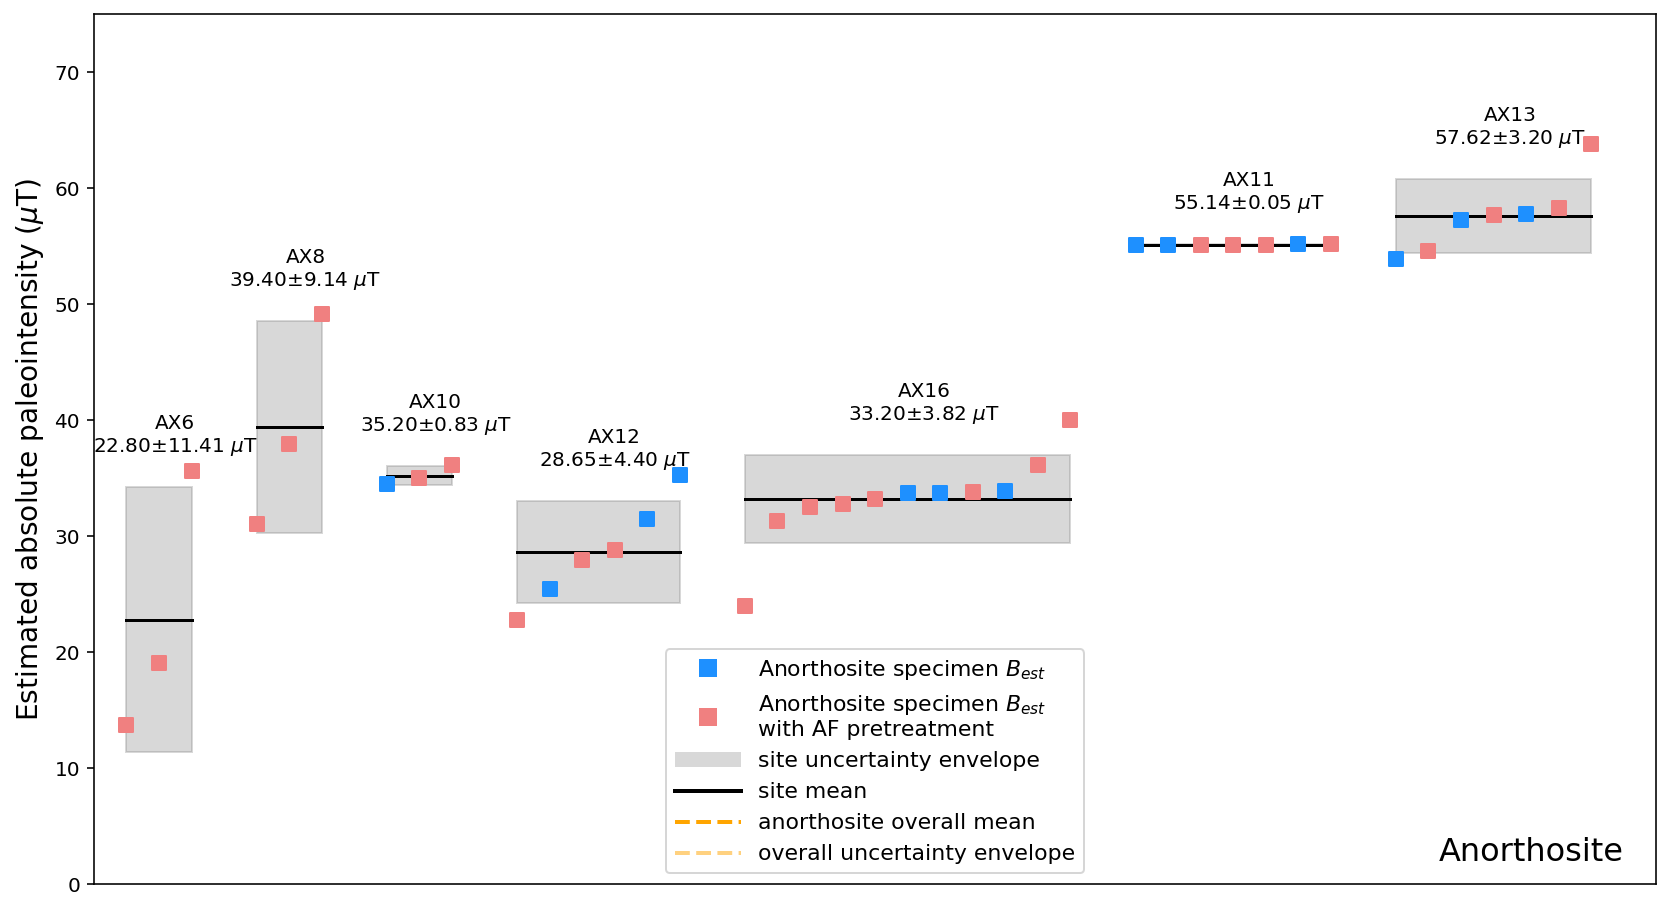

In [32]:
AX_PINT_data = get_PINT_data(AX_all_PINT_site, AX_all_PINT_specimen)
BD_PINT_data = get_PINT_data(BD_all_PINT_site, BD_all_PINT_specimen)

AX_site_mean_color = 'black'
AX_site_std_color = 'grey'
AX_spec_color = 'dodgerblue'
AX_grand_mean_color = 'orange'
AX_grand_std_color = 'orange'
BD_spec_color = 'navy'

fig, ax, mean, std = plot_PINT(AX_PINT_data[0], AX_PINT_data[1],
                               [i/cooling_rate_correction for i in AX_PINT_data[2]], 
                               [i/cooling_rate_correction for i in AX_PINT_data[3]], 
                               AX_PINT_data[4], 
                               AX_PINT_data[5], All_AF_spec_list, plot_weighted_mean=0)

AX_weighted_mean_color = 'orange'
plot_weighted_mean = 0
# labeling grand mean for AX
if plot_weighted_mean == True:
    ax.plot([-10, len(spec_int_uT)+50], [weighted_mean, weighted_mean], linestyle = 'dashed', color = weighted_mean_color)
    ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+7, mean-3, '%.2f' % mean + '$\pm$' + '%.2f' % std +' $\mu$T', color = AX_weighted_mean_color, horizontalalignment='right',fontsize=12)
    # making legends here
    custom_legends = [Line2D([0], [0], marker='s', color='w', markerfacecolor=AX_spec_color, markersize=10, label='Anorthosite specimen $B_{est}$'), 
#                       Line2D([0], [0], marker='d', color='w', markerfacecolor=BD_spec_color, markersize=10, label='Diabase specimen $B_{est}$'), 
                      Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Anorthosite with AF pretreatment'), 
#                       Line2D([0], [0], marker='d', color='w', markerfacecolor='orchid', markersize=10, label='Diabase with AF pretreatment'), 
                        Patch(facecolor=AX_site_std_color, edgecolor='none', lw = 5, alpha = 0.3, label='site uncertainty envelope'),
                        Line2D([0], [0], color=AX_site_mean_color, lw=2, label = 'site mean'),
                        Line2D([0], [0], color=AX_weighted_mean_color, ls = 'dashed', lw=2, label = 'anorthosite weighted mean'),
                        Patch(facecolor=AX_grand_std_color, edgecolor='none', lw = 5, alpha = 0.3, label= 'weighted uncertainty envelope')]
else:
#     ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+7, mean+1, '%.2f' % mean + ' $\pm$ ' + '%.2f' % std  +' $\mu$T', color = AX_grand_mean_color, horizontalalignment='right',fontsize=12)
    # making legends here
    custom_legends = [Line2D([0], [0], marker='s', color='w', markerfacecolor=AX_spec_color, markersize=10, label='Anorthosite specimen $B_{est}$'), 
#                       Line2D([0], [0], marker='d', color='w', markerfacecolor=BD_spec_color, markersize=10, label='Diabase specimen $B_{est}$'), 
                      Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Anorthosite specimen $B_{est}$\nwith AF pretreatment'), 
#                       Line2D([0], [0], marker='d', color='w', markerfacecolor='orchid', markersize=10, label='Diabase with AF pretreatment'),  
                        Patch(facecolor=AX_site_std_color, edgecolor='none', lw = 5, alpha = 0.3, label='site uncertainty envelope'),
                        Line2D([0], [0], color=AX_site_mean_color, lw=2, label = 'site mean'),
                        Line2D([0], [0], color=AX_grand_mean_color, ls = 'dashed', lw=2, label = 'anorthosite overall mean'),
                        Line2D([0], [0], color=AX_grand_std_color, linestyle = 'dashed', lw=2, alpha = 0.5, label = 'overall uncertainty envelope')]

ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+7, 2, 'Anorthosite', horizontalalignment='right',fontsize=16)   
# ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+14, 2, 'Diabase', horizontalalignment='right',fontsize=16) 
ax.set_xlim(0, len(AX_all_PINT_specimen.specimen_int_uT.tolist())+8)
ax.set_ylim(0,75)
ax.set_xticks([])
ax.set_ylabel('Estimated absolute paleointensity ($\mu$T)', fontsize = 14)

plt.legend(handles = custom_legends, loc = 8, handlelength = 3, fontsize=11)
# plt.title('Cooling rate corrected paleointensity estimates from the diabase and anorthosite')
# plt.savefig('code_output/Paleointensity_plot_cooling_corrected.pdf', bbox_inches='tight')
plt.show(fig)

In [33]:
np.round([i/cooling_rate_correction for i in AX_PINT_data[3]],2)

array([11.41,  9.14,  0.83,  4.4 ,  3.82,  0.05,  3.2 ])

## Perform student T test between sites in close proximities

In [34]:
def int_T_test(site1, site2):
    
    return stats.ttest_ind(site1['specimen_int_uT'].tolist(), site2['specimen_int_uT'].tolist())

In [35]:
AX6_spec = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX6')]
AX8_spec = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX8')]
AX10_spec = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX10')]
Carlton_spec = pd.concat([AX6_spec,AX8_spec,AX10_spec])

AX11_spec = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX11')]
AX13_spec = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX13')]
Kennedy_spec = pd.concat([AX11_spec,AX13_spec])

AX12_spec = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX12')]
AX16_spec = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX16')]
Silver_spec = pd.concat([AX12_spec,AX16_spec])

In [36]:
int_T_test(AX11_spec, AX13_spec)

Ttest_indResult(statistic=-2.035199064495471, pvalue=0.06453465471113273)

In [37]:
int_T_test(AX12_spec, AX16_spec)

Ttest_indResult(statistic=-2.2319930953182325, pvalue=0.0412902448126328)

In [38]:
int_T_test(Carlton_spec, Kennedy_spec)

Ttest_indResult(statistic=-8.285069153469104, pvalue=4.676525734733926e-08)

In [39]:
int_T_test(Carlton_spec, Silver_spec)

Ttest_indResult(statistic=0.3019103591786188, pvalue=0.7653211350685046)

In [40]:
int_T_test(Silver_spec, Kennedy_spec)

Ttest_indResult(statistic=-18.357486092356435, pvalue=1.652218457553909e-17)

# Put paleointensity result in context of historical compilation

## Import data 

First we import data from relatively recent geological history. This ‘Recent’ data set is the same used in Bono et al., 2021 and consists of measurements of VDM from the PINT database at the site-mean level that are derived from rocks with a stated age between 1 Myr and 300 Myr. Data further was filtered to only include results that met the STAT criterion and results from experiments that used the following techniques: T+ (Thellier with pTRM checks), M+ (Microwave with pTRM checks), LTD-DHT Shaw or some combination including at least one of these. To focus on the long-term average, we will look at values between 1 to 300 Ma (avoiding the high sampling of units 1 Ma or younger).

- Bono, R. K., Paterson, G. A., van der Boon, A., Engbers, Y. A., Grappone, J. M., Handford, B., ... & Biggin, A. J. (2021). The PINT database: A definitive compilation of absolute palaeomagnetic intensity determinations since 4 billion years ago. Geophysical Journal International.

In [41]:
# read in csv file
All_PINT_data = pd.read_csv('../data/PINT_compilation/All_PINT_data_Bono2021.csv')
All_PINT_data['VDM+VADM'] = [All_PINT_data['VADM'][i] if np.isnan(All_PINT_data['VDM'][i]) 
                             else All_PINT_data['VDM'][i] for i in range(All_PINT_data.shape[0])]
All_PINT_data['VDM+VADM'] = All_PINT_data['VDM+VADM']*10
# filter for records with Qpi index bigger than 3
All_PINT_data = All_PINT_data[All_PINT_data['QPI'] >=3]
All_PINT_data = All_PINT_data.loc[All_PINT_data.AGE > 0.99]

Paleointensity estimates generated from the Midcontinent Rift and Abitibi dikes were downloaded from the IAGA Paleointensity database and our new data were added to these data in the same format. In the code below, the IAGA Paleointensity data plus our new data are imported and then data from the Midcontinent Rift are split up by study.

In [42]:
MCR_PINT_database = pd.read_csv('../data/PINT_compilation/MCR_PINT_data.csv', 
                                skiprows=2)

To separate Midcontinent Rift data, we organized it into groups based on study. The 'Ref' column refers to the studies that the data was taken from. Within this column, 
* '199' refers to data from the Abitibi dikes presented in Macouin et al. (2003)
* '54' refers to various Midcontinent rift units presented in Pesonen and Halls (1983)
* '687' refers to data from the Lake Shore Traps reported in Kulakov et al. (2013)
* 'this study' refers to new data presented here 

A new dataframe is made for data from each of these studies.

In [43]:
MCR_PINT_Abitibi = MCR_PINT_database.loc[MCR_PINT_database.Ref == '199']
MCR_PINT_PH = MCR_PINT_database.loc[MCR_PINT_database.Ref == '54']
MCR_PINT_LST = MCR_PINT_database.loc[MCR_PINT_database.Ref == '687']
MCR_PINT_volc = MCR_PINT_database.loc[MCR_PINT_database.Ref == '733']
MCR_PINT_BBC = MCR_PINT_database.loc[MCR_PINT_database.Ref == 'this study']
MCR_PINT_BBC = MCR_PINT_BBC[MCR_PINT_BBC['IDENT'].str.contains('AX')]
MCR_PINT_BBC

,Data,IDENT,SLAT,SLONG,AGE,DAGE,AgeMtd,P,Country,Continent,...,DFPc,VDM,GROUP,TYPE,FORM,ROCKMAG,COMMENTS,LOCATION NAME,Ref,Changes from IAGA
64,NaN,AX6,47.582679,-90.856159,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,50.0,4.95,Igneous,Anorthosite,Intrusion,NaN,NaN,Beaver Bay Complex,this study,NaN
65,NaN,AX8,47.582675,-90.856173,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,23.2,8.44,Igneous,Anorthosite,Intrusion,NaN,NaN,Beaver Bay Complex,this study,NaN
66,NaN,AX10,47.582715,-90.856167,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,2.4,7.79,Igneous,Anorthosite,Intrusion,NaN,NaN,Beaver Bay Complex,this study,NaN
67,NaN,AX11,47.369985,-91.166488,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,0.1,12.36,Igneous,Anorthosite,Intrusion,NaN,NaN,Beaver Bay Complex,this study,NaN
68,NaN,AX12,47.292066,-91.260100,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,15.4,5.21,Igneous,Anorthosite,Intrusion,NaN,NaN,Beaver Bay Complex,this study,NaN
69,NaN,AX13,47.368892,-91.166955,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,5.6,12.92,Igneous,Anorthosite,Intrusion,NaN,NaN,Beaver Bay Complex,this study,NaN
70,NaN,AX16,47.288876,-91.263710,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,11.4,6.48,Igneous,Anorthosite,Intrusion,NaN,NaN,Beaver Bay Complex,this study,NaN


calculate average VDM for Abitibi dikes


In [44]:
MCR_PINT_Abitibi['VDM'].mean()*10

13.000000000000004

calculate average VDM for Osler volcanics

In [45]:
MCR_PINT_volc[MCR_PINT_volc['LOCATION NAME ']=='Osler Volcanic Group']['VDM'].mean()*10

72.0

calculate average VDM for Beaver River anorthosites

In [46]:
MCR_PINT_BBC['VDM'].mean()*10

83.07142857142858

We next separated the data from Pesonen and Halls (1983) based on geologic material which is indicated in the 'FORM' column. 

In [47]:
MCR_PINT_PH_intrusive = MCR_PINT_PH.loc[MCR_PINT_PH.FORM == 'Dyke ']
MCR_PINT_PH_flows = MCR_PINT_PH.loc[MCR_PINT_PH.FORM == 'Lava Flow ']
MCR_PINT_PH_baked = MCR_PINT_PH.loc[MCR_PINT_PH.FORM == 'Baked contact ']
MCR_PINT_PH_mixed = MCR_PINT_PH.loc[MCR_PINT_PH.FORM == 'Mixed']

Calculate the mean and standard deviation of paleointensity results from each study. Units are reported as $\text{ZAm}^2$.

In [48]:
print ("Mean of Pesonen and Halls")
print (np.mean(MCR_PINT_PH.VDM.tolist())*10)
print (np.std(MCR_PINT_PH.VDM.tolist())*10)
print ("\nMean of Sprain data")
print (np.mean(MCR_PINT_volc.VDM.tolist())*10)
print (np.std(MCR_PINT_volc.VDM.tolist())*10)
print ("\nMean of Abitibi")
print (np.mean(MCR_PINT_Abitibi.VDM.tolist())*10)
print (np.std(MCR_PINT_Abitibi.VDM.tolist())*10)
print ("\nMean of Lake Shore Traps")
print (np.mean(MCR_PINT_LST.VDM.tolist())*10)
print (np.std(MCR_PINT_LST.VDM.tolist())*10)
print ("\nMean of Sprain data + Lake Shore Traps")
print (np.mean(MCR_PINT_volc.VDM.tolist() + MCR_PINT_LST.VDM.tolist())*10)
print (np.std(MCR_PINT_volc.VDM.tolist() + MCR_PINT_LST.VDM.tolist())*10)

Mean of Pesonen and Halls
95.77142857142859
30.027243865357672

Mean of Sprain data
55.60000000000001
20.597087172704786

Mean of Abitibi
13.000000000000004
3.625307868699863

Mean of Lake Shore Traps
55.56666666666666
9.93875690863243

Mean of Sprain data + Lake Shore Traps
55.57142857142856
12.052944428136847


## Welch's T-tests

Conduct Welch's T-tests (assumes normal populations that have unequal variances) to test whether our new results share a common mean with past results from the Midcontinent Rift. If there is a large two-tailed p-value (i.e. large than 0.05 or 0.1), then the null hypothesis of identical averages cannot be rejected. 

In [49]:
stats.ttest_ind(MCR_PINT_PH.VDM.tolist(),
                MCR_PINT_volc.VDM.tolist(),
                equal_var=False)

Ttest_indResult(statistic=3.267570949241336, pvalue=0.011718386489727839)

In [50]:
stats.ttest_ind(MCR_PINT_LST.VDM.tolist(),
                MCR_PINT_volc.VDM.tolist(),
                equal_var=False)

Ttest_indResult(statistic=-0.003185948758165787, pvalue=0.99760163995563)

In [51]:
stats.ttest_ind(MCR_PINT_Abitibi.VDM.tolist(),
                MCR_PINT_volc.VDM.tolist(),
                equal_var=False)

Ttest_indResult(statistic=-4.094441697259933, pvalue=0.01373455542933557)

In [52]:
stats.ttest_ind(MCR_PINT_BBC.VDM.tolist(),
                MCR_PINT_volc.VDM.tolist(),
                equal_var=False)

Ttest_indResult(statistic=1.7232621840920064, pvalue=0.11560154087060905)

In [53]:
stats.ttest_ind(MCR_PINT_BBC.VDM.tolist(),
                MCR_PINT_Abitibi.VDM.tolist(),
                equal_var=False)

Ttest_indResult(statistic=5.716304395929815, pvalue=0.0011227346805680472)

## Plotted vs. time
### Expected range associated with latitudinal motion

The intensity of the geomagnetic field varies as a function of latitude with the field being two times stronger at the pole than the equator. Given that Laurentia moved from high to low latitudes during the development of the Midcontinent Rift, a constant axial dipole moment over this period would result in a decrease in local intensity through the history of rift volcanism.

Our new paleointensity estimates from the Osler Volcanic Group give a paleointensity estimate of ~45 μT. We can use the function **pmag.b_vdm** to calculate the VDM implied by this local field intensity for a paleolatitude of 45º.

In [54]:
vadm = pmag.b_vdm(45e-6,45) 
print (vadm)

7.359788340581947e+22


Our best current estimates are that the rate of latitudinal motion from higher to lower latitudes occured at a relatively constant rate of 17 cm/year. Using this rate, we can calculate predicted local field strength for a constant virtual axial dipole moment of $7.4 \times 10^{22} \text{A m}^2$.

In [55]:
time = np.arange(1080,1111,.1)

deg_Myr = ((17.0/100000)/111.0)*1000000
vadm = pmag.b_vdm(45e-6,45) 
paleolat = []
expected_intensity = []

for t in time:
    time_delta = 1105 - t
    paleolat.append(44 - (time_delta*deg_Myr))

for lat in paleolat:
    expected_intensity.append(pmag.vdm_b(vadm,lat)*10**6)

intensity_1111Ma = expected_intensity[-1]    

old_time = []
for dates in np.arange (1111,1143):
    old_time.append(dates)
    expected_intensity.append(intensity_1111Ma)
    
time = np.append(time,old_time) 

This predicted change resulting from latitudinal motion can be plotted along with published and new paleointensity estimates.

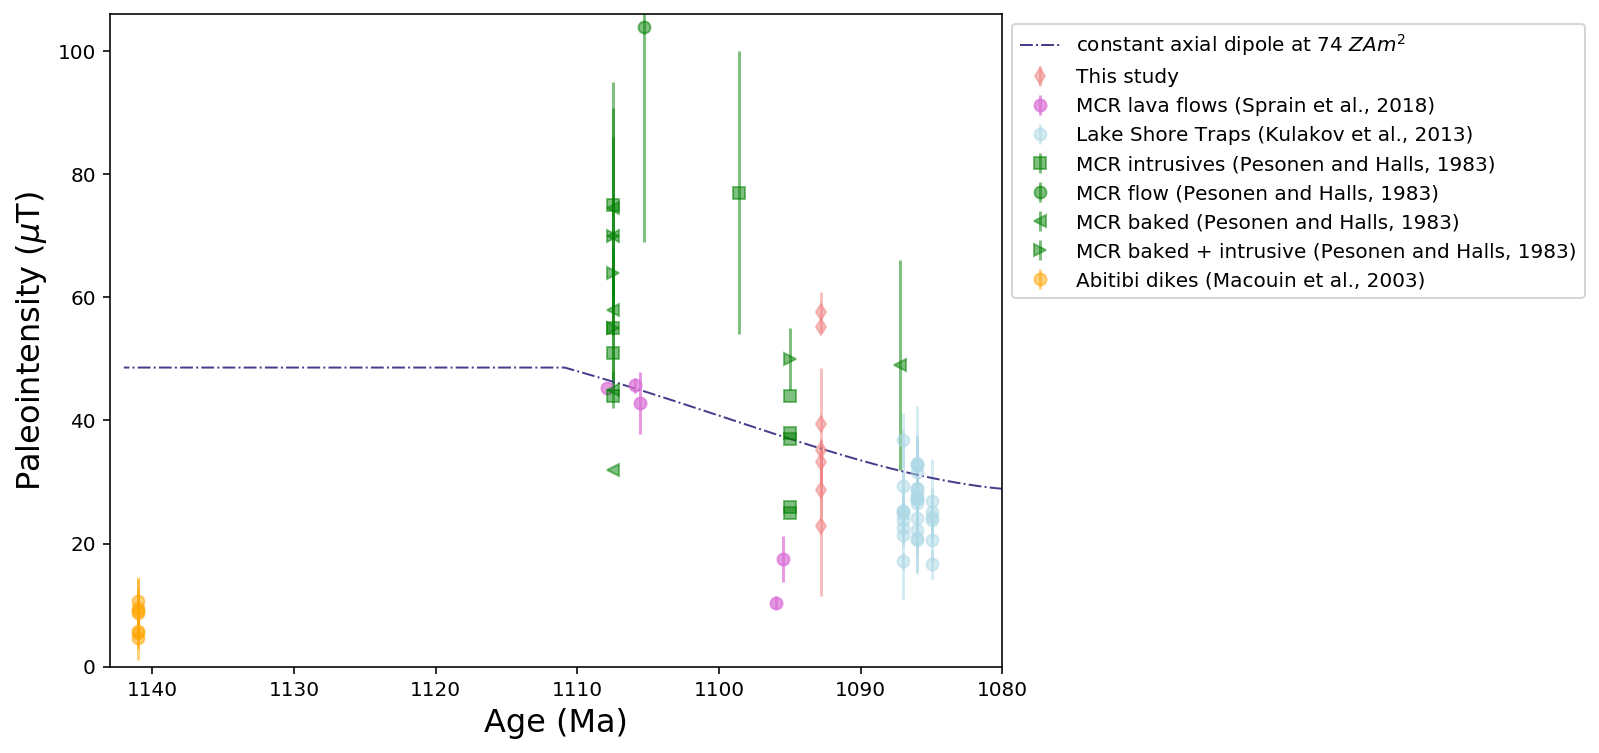

In [56]:
plt.figure(figsize=(8,6))
plt.errorbar(MCR_PINT_BBC['AGE'].tolist(),MCR_PINT_BBC['F'].tolist(), 
             yerr=MCR_PINT_BBC['DF'].tolist(), color='lightcoral',fmt ='d', 
             label = 'This study',
             alpha=0.5)
plt.errorbar(MCR_PINT_volc['AGE'].tolist(),MCR_PINT_volc['F'].tolist(), 
             yerr=MCR_PINT_volc['DF'].tolist(),color='orchid',fmt ='o', 
             label = 'MCR lava flows (Sprain et al., 2018)',alpha=0.7)
plt.errorbar(MCR_PINT_LST['AGE'].tolist(),MCR_PINT_LST['F'].tolist(), 
             yerr=MCR_PINT_LST['DF'].tolist(), color='lightblue', fmt ='o', 
             label = 'Lake Shore Traps (Kulakov et al., 2013)',alpha=0.5)
plt.errorbar(MCR_PINT_PH_intrusive['AGE'].tolist(),
             MCR_PINT_PH_intrusive['F'].tolist(), 
             yerr=MCR_PINT_PH_intrusive['DF'].tolist(),
             color='green',fmt ='s', 
             label = 'MCR intrusives (Pesonen and Halls, 1983)',alpha=0.5)
plt.errorbar(MCR_PINT_PH_flows['AGE'].tolist(),
             MCR_PINT_PH_flows['F'].tolist(), 
             yerr=MCR_PINT_PH_flows['DF'].tolist(),
             color='green',fmt ='o', 
             label = 'MCR flow (Pesonen and Halls, 1983)',alpha=0.5)
plt.errorbar(MCR_PINT_PH_baked['AGE'].tolist(),
             MCR_PINT_PH_baked['F'].tolist(), 
             yerr=MCR_PINT_PH_baked['DF'].tolist(),
             color='green',fmt ='<', 
             label = 'MCR baked (Pesonen and Halls, 1983)',alpha=0.5)
plt.errorbar(MCR_PINT_PH_mixed['AGE'].tolist(),
             MCR_PINT_PH_mixed['F'].tolist(), 
             yerr=MCR_PINT_PH_mixed['DF'].tolist(),
             color='green',fmt ='>', 
             label = 'MCR baked + intrusive (Pesonen and Halls, 1983)',
             alpha=0.5)
plt.errorbar(MCR_PINT_Abitibi['AGE'].tolist(),MCR_PINT_Abitibi['F'].tolist(), 
             yerr=MCR_PINT_Abitibi['DF'].tolist(), color='orange',fmt ='o', 
             label = 'Abitibi dikes (Macouin et al., 2003)',
             alpha=0.5)

plt.plot(time,expected_intensity, label='constant axial dipole at 74 $ZAm^2$', 
         c='darkslateblue', linestyle='dashdot', linewidth=1)
plt.xlim(1080,1143)
plt.ylim(0,106)
plt.ylabel(r'Paleointensity ($\mu$T)', fontsize = 16)
plt.xlabel('Age (Ma)', fontsize = 16)
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1))
plt.gca().invert_xaxis()
# plt.savefig('../figure/MCR_Paleointensity.pdf', bbox_inches='tight')
plt.show()

In [57]:
all_MCR = pd.concat([MCR_PINT_BBC, MCR_PINT_volc, MCR_PINT_LST, MCR_PINT_PH_intrusive, MCR_PINT_PH_flows, MCR_PINT_PH_baked, MCR_PINT_PH_mixed])
MCR_median = all_MCR['VDM'].median()*10
MCR_median

64.80000000000001

In [58]:
np.std(all_MCR['VDM']*10)

28.842501742697802

In [59]:
np.mean(all_MCR['VDM']*10)

72.02698412698412

In [60]:
MCR_PINT_BBC['VDM'].median()*10

77.9

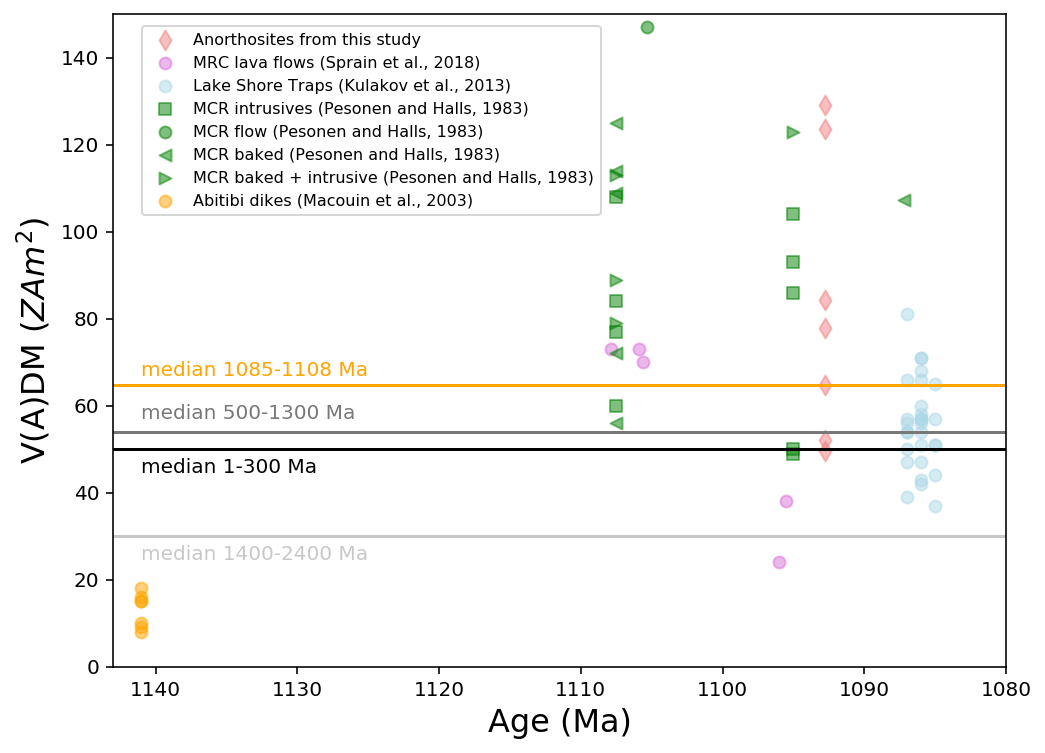

In [61]:
plt.figure(figsize=(8,6))
plt.scatter(MCR_PINT_BBC['AGE'],MCR_PINT_BBC['VDM']*10, s = 50,
             color='lightcoral',marker ='d', 
            label = 'Anorthosites from this study',alpha=0.5)
plt.scatter(MCR_PINT_volc['AGE'],MCR_PINT_volc['VDM']*10, 
             color='orchid',marker ='o', 
            label = 'MRC lava flows (Sprain et al., 2018)',alpha=0.5)
plt.scatter(MCR_PINT_LST['AGE'],MCR_PINT_LST['VDM']*10, 
             color='lightblue',marker ='o',
            label = 'Lake Shore Traps (Kulakov et al., 2013)',alpha=0.5)
plt.scatter(MCR_PINT_PH_intrusive['AGE'],MCR_PINT_PH_intrusive['VDM']*10, 
             color='green',marker ='s', 
            label = 'MCR intrusives (Pesonen and Halls, 1983)',alpha=0.5)
plt.scatter(MCR_PINT_PH_flows['AGE'],MCR_PINT_PH_flows['VDM']*10, 
             color='green',marker ='o', 
            label = 'MCR flow (Pesonen and Halls, 1983)',alpha=0.5)
plt.scatter(MCR_PINT_PH_baked['AGE'],MCR_PINT_PH_baked['VDM']*10, 
             color='green',marker ='<', 
            label = 'MCR baked (Pesonen and Halls, 1983)',alpha=0.5)
plt.scatter(MCR_PINT_PH_mixed['AGE'],MCR_PINT_PH_mixed['VDM']*10, 
             color='green',marker ='>', 
            label = 'MCR baked + intrusive (Pesonen and Halls, 1983)',alpha=0.5)
plt.scatter(MCR_PINT_Abitibi['AGE'],MCR_PINT_Abitibi['VDM']*10, 
             color='orange',marker ='o', 
            label = 'Abitibi dikes (Macouin et al., 2003)',alpha=0.5)

plt.xlim(1080,1143)
plt.ylim(0,150)

plt.axhline(y=50,color='#000000')
plt.text(1141,48,'median 1-300 Ma',color='#000000',
         verticalalignment='top')
plt.axhline(y=54,color='#787878')
plt.text(1141,56,'median 500-1300 Ma',color='#787878',
         verticalalignment='bottom')
plt.axhline(y=30,color='#C8C8C8')
plt.text(1141,28,'median 1400-2400 Ma',color='#C8C8C8',
         verticalalignment='top')

plt.axhline(y=MCR_median,color='orange')
plt.text(1141,MCR_median+5.5,'median 1085-1108 Ma',color='orange',
         verticalalignment='top')

plt.ylabel(r'V(A)DM $(ZAm^2)$', fontsize = 16)
plt.xlabel('Age (Ma)', fontsize = 16)
plt.legend(bbox_to_anchor=(0.555,0.68), prop={'size':8})
plt.gca().invert_xaxis()
# plt.savefig('code_output/MCR_VADM.pdf', bbox_inches='tight')
plt.show()

## In context of 300 - 1300 Ma PINT compilation

In [62]:
PINT_data = All_PINT_data
PINT_data = PINT_data[PINT_data['REF'] != 54]
PINT_data = PINT_data[PINT_data['QPI'] >=3]
PINT_data = PINT_data.dropna(subset=['INC', 'INTM', 'B', 'NINT'])
# PINT_data['INC'] = PINT_data['INC'].astype(np.float)
# PINT_data = PINT_data.drop(PINT_data[PINT_data['IntM']== '&nbsp;'].index)
# PINT_data = PINT_data.drop(PINT_data[PINT_data['F']== '&nbsp;'].index)
# PINT_data['F'] = PINT_data['F'].astype(np.float)
# PINT_data = PINT_data.drop(PINT_data[PINT_data['Nint']== '&nbsp;'].index)

PINT_data['Plat'] = [pmag.plat(i) for i in PINT_data['INC'].tolist()]
PINT_data['VDM'] = [pmag.b_vdm(PINT_data['B'].tolist()[i]/1000000, PINT_data['Plat'].tolist()[i]) 
                               for i in range(PINT_data.shape[0])]

# PINT_data['Nint'] = PINT_data['NINT'].astype(np.float)
# PINT_data['AGE'] = PINT_data['AGE'].astype(np.float)
PINT_data['VDM'] = PINT_data['VDM'].astype(np.float)/1e21


PINT_data = PINT_data.dropna(axis=0, subset=['VDM'])

# PINT_data = PINT_data.drop(PINT_data[PINT_data['AGE'] == '433-448'].index)
PINT_data.head()

,UID,OLD_DATA,REF,IDENT,SLAT,SLONG,AGE,DAGE,AGEMTD,CONTINENT,...,QALT,QMD,QACN,QTECH,QLITH,QMAG,QDIR,QPI,VDM+VADM,Plat
1147,3964,NaN,706,TT35,28.3,343.53,0.9910,0.0230,Interpolation,Atlantic Ocean,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,57.000,-10.314105
1148,3965,NaN,706,TT37,28.3,343.53,0.9910,0.0230,Interpolation,Atlantic Ocean,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,49.000,-7.630740
1151,3968,NaN,706,TT50,28.3,343.53,0.9925,0.0115,Interpolation,Atlantic Ocean,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,37.000,9.605755
1159,227,242,25,CA,-17.7,210.30,1.0000,0.1000,K-Ar,Pacific Ocean,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,126.835,-15.917883
1160,228,243,25,M2C,-17.7,210.30,1.0000,0.1000,K-Ar,Pacific Ocean,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.563,38.665651


## additional filtering and adjustments of the PINT database
in addition, we made adjustments to a few records in that the assgined dates are out-dated:
- Ref 183 Tudor Gabbro paleointensity by Yu and Dunlop 2001 should not be of age 1100 Ma but < 1000 Ma
- Ref 696 Central Arizona diabase sills by Donadini et al., 2011 should not be of age 1145 Ma but recent high precision U/Pb dates show 1098 Ma age (unpublished data from Boise State University)

- we do not include Celino et al., 2007 data due to the double slope issue 
- we do not include Ueno 1995 antarctica paleointensity data due to the K-Ar poor age dating and significant double-slope issue
- we do not include Salminen et al., 2006 Jänisjärvi impactite data due to the double-slope issue

In [63]:
PINT_post_500 = PINT_data[PINT_data['AGE']<500]


PINT_pre_500 = PINT_data[PINT_data['AGE'] >=500]

# drop Pesonen and Kulakov and Sprain data, Sprain will replot later
PINT_pre_500 = PINT_pre_500.drop(PINT_pre_500[(PINT_pre_500['REF'] == '54') 
                                              | (PINT_pre_500['REF'] == '687') | (PINT_pre_500['REF'] == '733')  
                                              | (PINT_pre_500['REF'] == '625') | (PINT_pre_500['REF'] == '177') 
                                              | (PINT_pre_500['REF'] == '627') ].index)

# drop Abitibi dikes data here but will replot later
PINT_pre_500 = PINT_pre_500.drop(PINT_pre_500[PINT_pre_500['REF'] == 199].index)

In [64]:
def sort_contribution(dataframe, correct_int_unit=True):
    if 'age_sigma' not in dataframe.columns:
        dataframe['age_sigma'] = dataframe['age']-dataframe['age_low']
    if correct_int_unit:
        dataframe['int_abs'] = dataframe['int_abs']*1e6
    dataframe['paleolatitude'] = [pmag.plat(i) for i in dataframe['dir_inc'].tolist()]
    dataframe['VDM'] = [pmag.b_vdm(dataframe['int_abs'].tolist()[i]/1e6, dataframe['paleolatitude'].tolist()[i]) /1e21
                                   for i in range(dataframe.shape[0])]
    
    return dataframe

In [65]:
Shcherbakova2017a_data = pd.read_csv('../data/PINT_compilation/Shcherbakova2017a.csv')
Shcherbakova2017a_data = sort_contribution(Shcherbakova2017a_data, correct_int_unit=0)

Shcherbakova2019a_data = pd.read_csv('../data/PINT_compilation/Shcherbakova2019a.csv')
Shcherbakova2019a_data = sort_contribution(Shcherbakova2019a_data, correct_int_unit=0)

Shcherbakova2021a_data = pd.read_csv('../data/PINT_compilation/Shcherbakova2021a.csv')
Shcherbakova2021a_data = sort_contribution(Shcherbakova2021a_data, correct_int_unit=0)

Hawkins2019a_data = pd.read_csv('../data/PINT_compilation/Hawkins2019a.csv')
Hawkins2019a_data = sort_contribution(Hawkins2019a_data, correct_int_unit=0)

Hawkins2021a_data = pd.read_csv('../data/PINT_compilation/Hawkins2021a.csv')
Hawkins2021a_data['VDM'] = Hawkins2021a_data['VDM']*10

Kodama2019a_data = pd.read_csv('../data/PINT_compilation/Kodama2019a.csv')
Kodama2019a_data = sort_contribution(Kodama2019a_data, correct_int_unit=0)

Bono_2019_data = pd.read_csv('../data/PINT_compilation/Bono2019_data.csv')
Bono_2019_data['VDM'] = Bono_2019_data['VDM']*10
Bono_2019_data['sigma'] = Bono_2019_data['sigma']*10

Lloyd2021a_data = pd.read_csv('../data/PINT_compilation/Lloyd2021a.csv', header=1)
Lloyd2021a_data = sort_contribution(Lloyd2021a_data)

Lloyd2021b_data = pd.read_csv('../data/PINT_compilation/Lloyd2021b.csv')
Lloyd2021b_data['VDM'] = Lloyd2021b_data['VDM']*10
Lloyd2021b_data['VDM_sigma'] = Lloyd2021b_data['VDM_sigma']*10

Thallner2021a_data = pd.read_csv('../data/PINT_compilation/Thallner2021a.csv', header=1)
Thallner2021a_data = sort_contribution(Thallner2021a_data)
Thallner2021b_data = pd.read_csv('../data/PINT_compilation/Thallner2021b.csv', header=1)
Thallner2021b_data = sort_contribution(Thallner2021b_data)

### calculate polynomial fit for Bono et al., 2019 compilation

In [66]:
new_x = np.linspace(565, 3500, 100)
coefs = poly.polyfit(Bono_2019_data['Age'], Bono_2019_data['VDM'], 2)
fit_y = poly.polyval(new_x, coefs)

### calculate MCR mean using Sprain et al., 2018 data and this study 

In [67]:
MCR_mean = np.mean(MCR_PINT_volc['VDM'].tolist()+MCR_PINT_BBC['VDM'].tolist())*10

The selected Proterozoic paleointensity data are: 
- ca. 1000 Ma Tudor Gabbro 
- ca. 1098 Ma Central Arizona sills 
- ca. 1267 Ma Mackenzie dike swarm
- ca. 1450 Ma Riphaean dyke complexes in the Lake Ladoga region (Northwestern Russia)

## PADM2M variability

In [68]:
PADM2M = pd.read_csv('../data/PINT_compilation/padm2m.adms.1k', sep=" +", header=None)
PADM2M

,0,1,2,3
0,0.000,7.556655,1140.355800,-1022666.900
1,0.001,8.516242,1109.382200,960719.720
2,0.002,9.568050,454.993170,-2272107.300
3,0.003,9.159584,-996.890980,-626777.790
4,0.004,8.095548,-885.065030,850169.660
...,...,...,...,...
1996,1.996,6.131238,-51.854323,145105.970
1997,1.997,6.118615,-6.714244,-55048.055
1998,1.998,6.026336,-235.883150,-403285.020
1999,1.999,5.531559,-810.922410,-746357.480


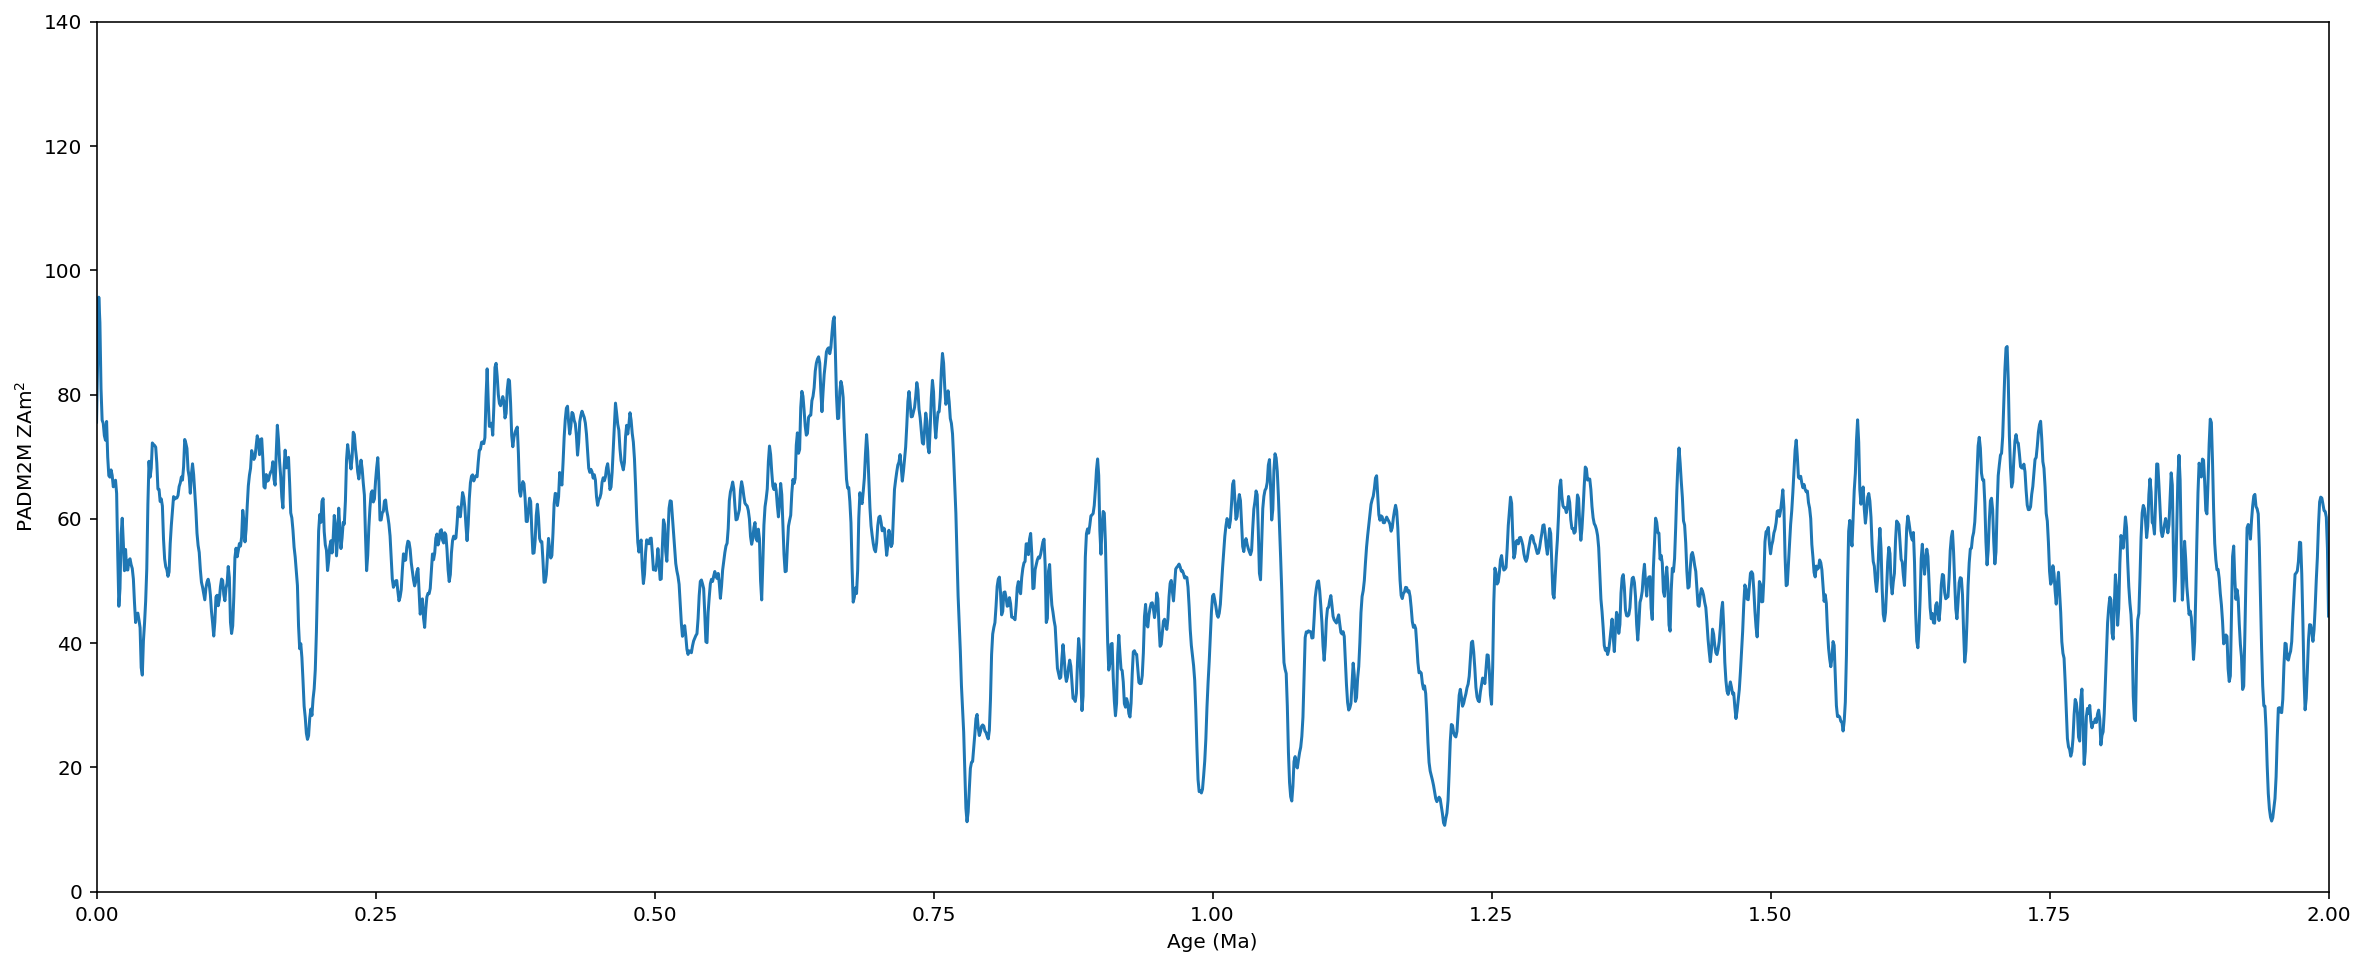

In [69]:
plt.figure(figsize=(20, 8))
plt.plot(PADM2M[0], PADM2M[1]*10)
plt.xlim(0, 2)
plt.ylim(0, 140)
plt.xlabel('Age (Ma)')
plt.ylabel('PADM2M ZAm$^2$')
plt.show()

In [70]:
PADM2M_resamples = []
for i in range(10000):
    PADM2M_resamples.append(pmag.vdm_b(PADM2M[1].sample(n=3).mean()*1e22, 22)*1e6)
PADM2M_ALL = pmag.vdm_b(PADM2M[1]*1e22, 22)*1e6

In [71]:
AX11_13_mean = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX11|AX13')].specimen_int_uT.mean()
AX11_13_std = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX11|AX13')].specimen_int_uT.std()
AX12_16_mean = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX12|AX16')].specimen_int_uT.mean()
AX12_16_std = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX12|AX16')].specimen_int_uT.std()
AX6_8_10_mean = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX6|AX8|AX10')].specimen_int_uT.mean()
AX6_8_10_std = AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX6|AX8|AX10')].specimen_int_uT.std()

region_mean = (AX6_8_10_mean+AX12_16_mean+AX11_13_mean)/3
region_std = np.std([AX6_8_10_mean,AX12_16_mean,AX11_13_mean])

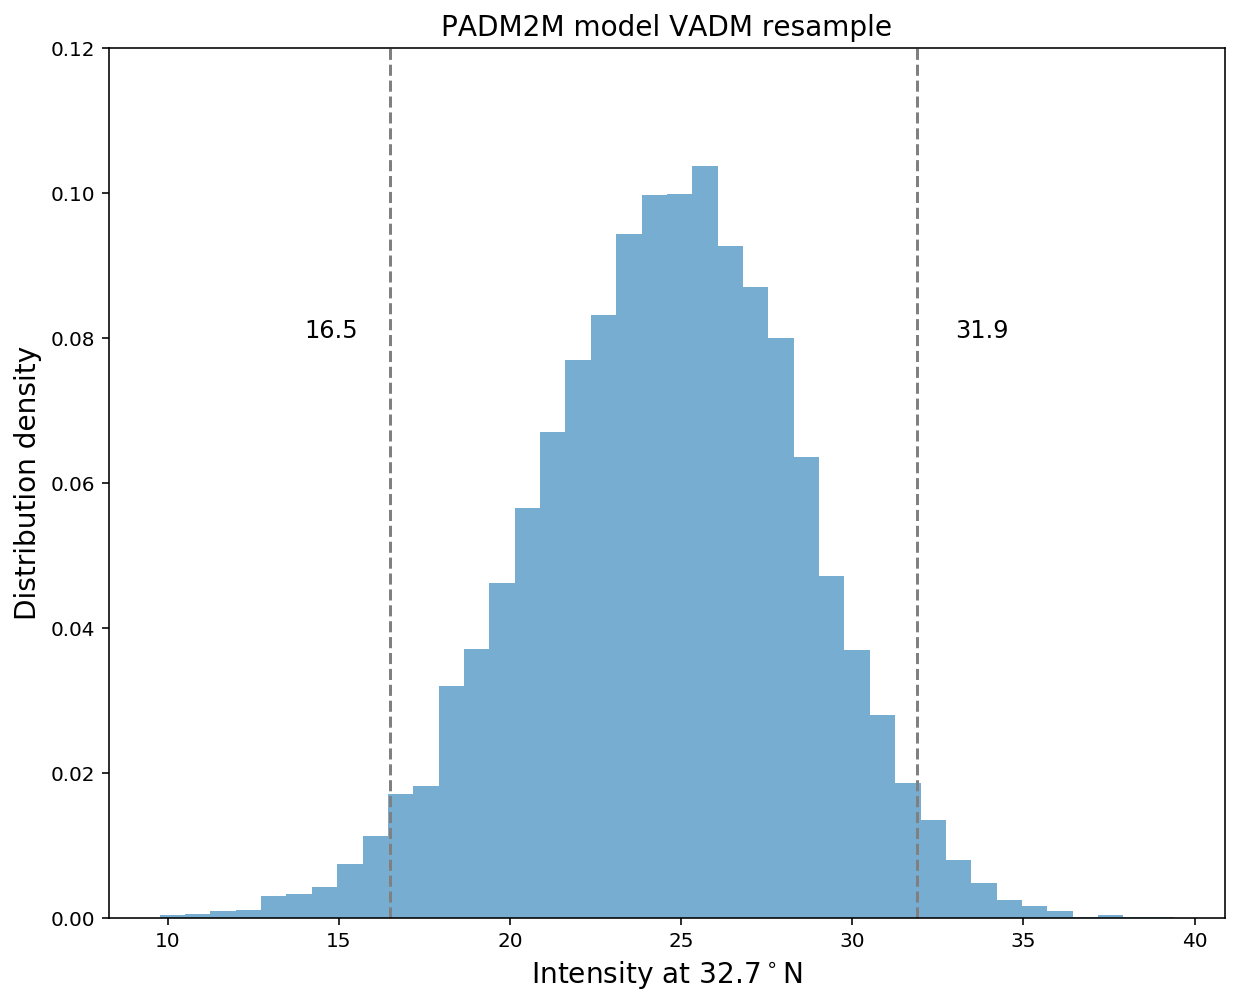

In [72]:
PADM2M_resample_low, PADM2M_resample_high = np.round(np.percentile(PADM2M_resamples, [2.5, 97.5]), 1)
plt.figure(figsize=(10, 8))

plt.hist(PADM2M_resamples, bins=40, density=1, color='C0', alpha=0.6, orientation='vertical')
plt.plot([PADM2M_resample_low, PADM2M_resample_low], [0, 1], c='grey', ls='--')
plt.plot([PADM2M_resample_high, PADM2M_resample_high], [0, 1], c='grey', ls='--')

plt.text(14, 0.08, str(PADM2M_resample_low), fontdict={'fontsize':12})
plt.text(33, 0.08, str(PADM2M_resample_high), fontdict={'fontsize':12})
plt.ylim(0, 0.12)
# plt.ylim(0,75)

plt.title('PADM2M model VADM resample', fontsize=14)
plt.xlabel('Intensity at 32.7$^\circ$N', fontsize=14)
plt.ylabel('Distribution density', fontsize=14)
# plt.savefig('code_output/PADM2M_resample.pdf', bbox_inches='tight')
plt.show()

38.858216970998924 12.099477190714836
53.51550776092386
5.809489438044053


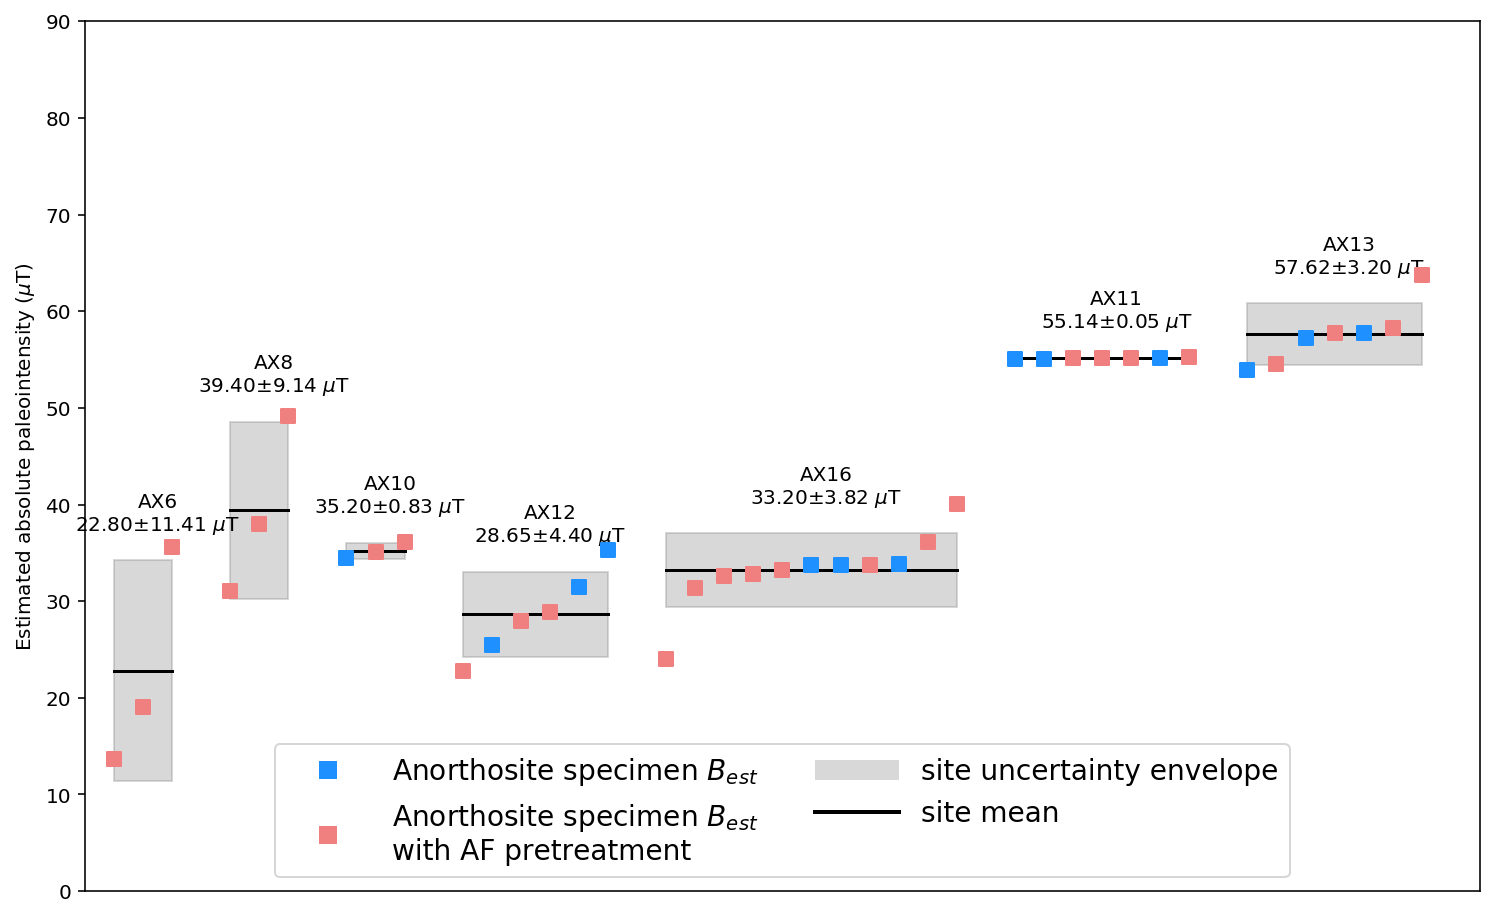

In [73]:
AX_PINT_data = get_PINT_data(AX_all_PINT_site, AX_all_PINT_specimen)
BD_PINT_data = get_PINT_data(BD_all_PINT_site, BD_all_PINT_specimen)

AX_site_mean_color = 'black'
AX_site_std_color = 'grey'
AX_spec_color = 'dodgerblue'
AX_grand_mean_color = 'orange'
AX_grand_std_color = 'orange'
BD_spec_color = 'navy'

fig, ax, mean, std = plot_PINT(AX_PINT_data[0], AX_PINT_data[1],
                               [i/cooling_rate_correction for i in AX_PINT_data[2]], 
                               [i/cooling_rate_correction for i in AX_PINT_data[3]], 
                               AX_PINT_data[4], 
                               AX_PINT_data[5], All_AF_spec_list, plot_weighted_mean=0, figsize=(12.5, 8))

AX_weighted_mean_color = 'orange'
plot_weighted_mean = 0
# labeling grand mean for AX
if plot_weighted_mean == True:
    ax.plot([-10, len(spec_int_uT)+50], [weighted_mean, weighted_mean], linestyle = 'dashed', color = weighted_mean_color)
    ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+7, mean-3, '%.2f' % mean + '$\pm$' + '%.2f' % std +' $\mu$T', color = AX_weighted_mean_color, horizontalalignment='right',fontsize=12)
    # making legends here
    custom_legends = [Line2D([0], [0], marker='s', color='w', markerfacecolor=AX_spec_color, markersize=10, label='Anorthosite specimen $B_{est}$'), 
#                       Line2D([0], [0], marker='d', color='w', markerfacecolor=BD_spec_color, markersize=10, label='Diabase specimen $B_{est}$'), 
                      Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Anorthosite with AF pretreatment'), 
#                       Line2D([0], [0], marker='d', color='w', markerfacecolor='orchid', markersize=10, label='Diabase with AF pretreatment'), 
                        Patch(facecolor=AX_site_std_color, edgecolor='none', lw = 5, alpha = 0.3, label='site uncertainty envelope'),
                        Line2D([0], [0], color=AX_site_mean_color, lw=2, label = 'site mean'),
                        Line2D([0], [0], color=AX_weighted_mean_color, ls = 'dashed', lw=2, label = 'anorthosite weighted mean'),
                        Patch(facecolor=AX_grand_std_color, edgecolor='none', lw = 5, alpha = 0.3, label= 'weighted uncertainty envelope')]
else:
#     ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+7, mean+1, '%.2f' % mean + ' $\pm$ ' + '%.2f' % std  +' $\mu$T', color = AX_grand_mean_color, horizontalalignment='right',fontsize=12)
    # making legends here
    custom_legends = [Line2D([0], [0], marker='s', color='w', markerfacecolor=AX_spec_color, markersize=10, label='Anorthosite specimen $B_{est}$'), 
#                       Line2D([0], [0], marker='d', color='w', markerfacecolor=BD_spec_color, markersize=10, label='Diabase specimen $B_{est}$'), 
                      Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Anorthosite specimen $B_{est}$\nwith AF pretreatment'), 
#                       Line2D([0], [0], marker='d', color='w', markerfacecolor='orchid', markersize=10, label='Diabase with AF pretreatment'),  
                        Patch(facecolor=AX_site_std_color, edgecolor='none', lw = 5, alpha = 0.3, label='site uncertainty envelope'),
                        Line2D([0], [0], color=AX_site_mean_color, lw=2, label = 'site mean'),]
#                         Line2D([0], [0], color=AX_grand_mean_color, ls = 'dashed', lw=2, label = 'anorthosite overall mean'),
#                         Line2D([0], [0], color=AX_grand_std_color, linestyle = 'dashed', lw=2, alpha = 0.5, label = 'overall uncertainty envelope')]

# ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+7, 2, 'Anorthosite', horizontalalignment='right',fontsize=16)   
# ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+14, 2, 'Diabase', horizontalalignment='right',fontsize=16) 
ax.set_xlim(0, len(AX_all_PINT_specimen.specimen_int_uT.tolist())+8)
ax.set_ylim(0,90)
ax.set_xticks([])
ax.set_ylabel('Estimated absolute paleointensity ($\mu$T)')

plt.legend(handles = custom_legends, loc = 8, handlelength = 3, fontsize=14, ncol=2)
# plt.title('Cooling rate corrected paleointensity estimates from the diabase and anorthosite')
# plt.savefig('code_output/Paleointensity_plot_cooling_corrected.pdf', bbox_inches='tight')
plt.show(fig)

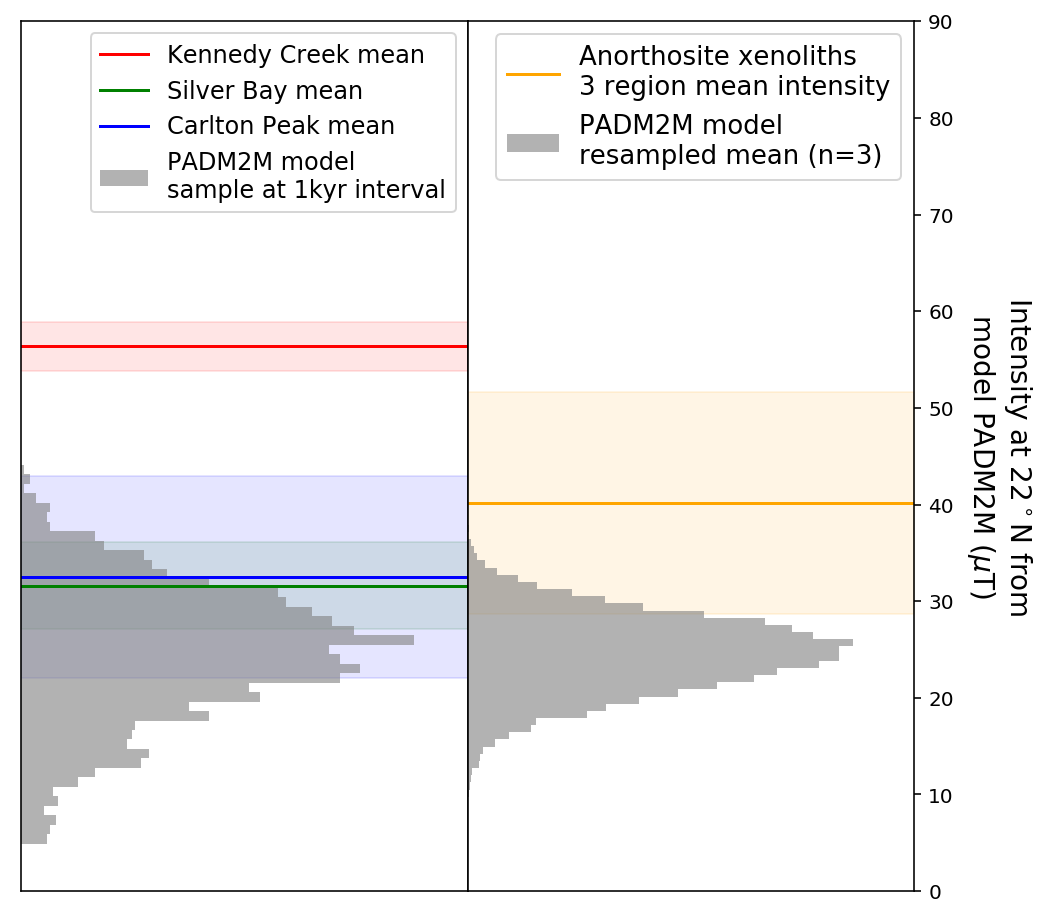

In [74]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.hist(PADM2M_ALL, bins=40, density=1, color='grey', alpha=0.6, orientation='horizontal', label='PADM2M model\nsample at 1kyr interval')
ax1.axhline(AX11_13_mean, color = 'r', label = 'Kennedy Creek mean')
ax1.axhline(AX12_16_mean, color = 'g', label = 'Silver Bay mean')
ax1.axhline(AX6_8_10_mean, color = 'b', label = 'Carlton Peak mean')

ax1.fill_between([0, 0.1], [AX11_13_mean-AX11_13_std, AX11_13_mean-AX11_13_std], [AX11_13_mean+AX11_13_std, AX11_13_mean+AX11_13_std], color = 'r', alpha =0.1)
ax1.fill_between([0, 0.1], [AX12_16_mean-AX12_16_std, AX12_16_mean-AX12_16_std], [AX12_16_mean+AX12_16_std, AX12_16_mean+AX12_16_std], color = 'g', alpha =0.1)
ax1.fill_between([0, 0.1], [AX6_8_10_mean-AX6_8_10_std, AX6_8_10_mean-AX6_8_10_std], [AX6_8_10_mean+AX6_8_10_std, AX6_8_10_mean+AX6_8_10_std], color = 'b', alpha =0.1)
ax1.set_xlim(0, 0.08)

ax2.hist(PADM2M_resamples, bins=40, density=1, color='grey', alpha=0.6, orientation='horizontal', label='PADM2M model\nresampled mean (n=3)')
ax2.axhline(region_mean, color = 'orange', label = 'Anorthosite xenoliths\n3 region mean intensity')
ax2.fill_between([0, .12], [region_mean-region_std, region_mean-region_std], [region_mean+region_std, region_mean+region_std], color = 'orange', alpha =0.1)
ax2.set_xlim(0, 0.12)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(0,90)
ax1.legend(loc=1, fontsize=12)

ax2.set_xticks([])
ax2.set_ylim(0,90)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.legend(loc=1, fontsize=13)
plt.ylabel('Intensity at 22$^\circ$N from\nmodel PADM2M ($\mu$T)', fontsize=14, rotation=-90, labelpad=40)

plt.subplots_adjust(wspace=0.)
# plt.tight_layout()
# plt.savefig('code_output/PADM2M_resample.pdf', bbox_inches='tight')

plt.show()

In [75]:
region_mean

40.14686274509804

In [76]:
np.percentile(PADM2M_resamples, [99])

array([33.140563325652415])

## calculating 99% of Cenozoic values and calculate Cenozoic variability

In [77]:
PINT_66Ma = All_PINT_data[All_PINT_data.AGE < 66]
np.percentile(PINT_66Ma['VDM+VADM'].dropna(), [98])

array([123.31999999999994])

In [78]:
Cenozoic_resamples = []

for i in range(10000):
    Cenozoic_resamples.append(pmag.vdm_b(PINT_66Ma['VDM+VADM'].dropna().sample(n=3).mean()*1e21, 22)*1e6)
    
Cenozoic_all = pmag.vdm_b(PINT_66Ma['VDM+VADM'].dropna()*1e21, 22)*1e6


In [79]:
np.percentile(Cenozoic_resamples, [97])

array([38.412769760044476])

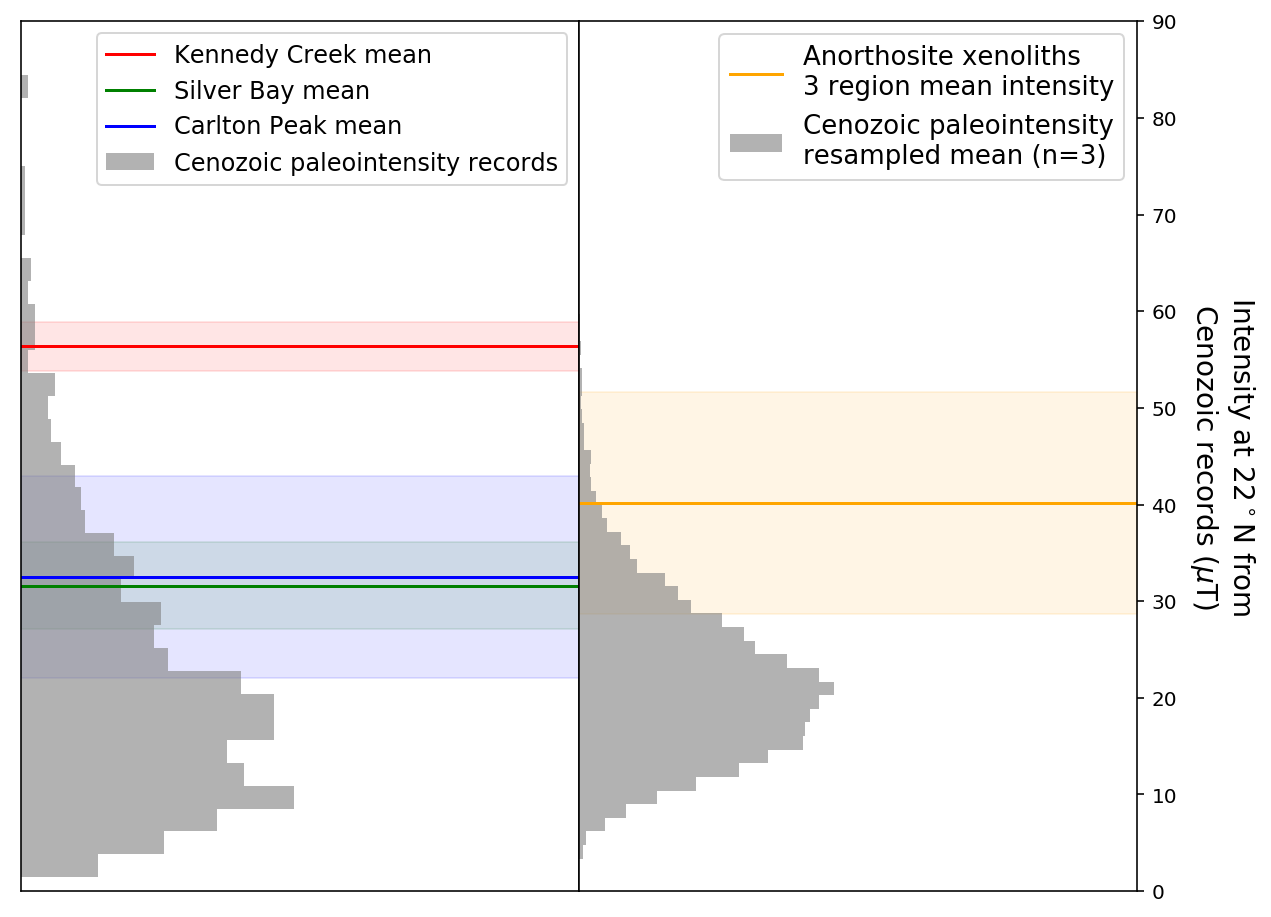

In [80]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.hist(Cenozoic_all, bins=40, density=1, color='grey', alpha=0.6, orientation='horizontal', label='Cenozoic paleointensity records')
ax1.axhline(AX11_13_mean, color = 'r', label = 'Kennedy Creek mean')
ax1.axhline(AX12_16_mean, color = 'g', label = 'Silver Bay mean')
ax1.axhline(AX6_8_10_mean, color = 'b', label = 'Carlton Peak mean')

ax1.fill_between([0, 0.1], [AX11_13_mean-AX11_13_std, AX11_13_mean-AX11_13_std], [AX11_13_mean+AX11_13_std, AX11_13_mean+AX11_13_std], color = 'r', alpha =0.1)
ax1.fill_between([0, 0.1], [AX12_16_mean-AX12_16_std, AX12_16_mean-AX12_16_std], [AX12_16_mean+AX12_16_std, AX12_16_mean+AX12_16_std], color = 'g', alpha =0.1)
ax1.fill_between([0, 0.1], [AX6_8_10_mean-AX6_8_10_std, AX6_8_10_mean-AX6_8_10_std], [AX6_8_10_mean+AX6_8_10_std, AX6_8_10_mean+AX6_8_10_std], color = 'b', alpha =0.1)
ax1.set_xlim(0, 0.08)

ax2.hist(Cenozoic_resamples, bins=40, density=1, color='grey', alpha=0.6, orientation='horizontal', label='Cenozoic paleointensity\nresampled mean (n=3)')
ax2.axhline(region_mean, color = 'orange', label = 'Anorthosite xenoliths\n3 region mean intensity')
ax2.fill_between([0, .12], [region_mean-region_std, region_mean-region_std], [region_mean+region_std, region_mean+region_std], color = 'orange', alpha =0.1)
ax2.set_xlim(0, 0.12)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(0,90)
ax1.legend(loc=1, fontsize=12)

ax2.set_xticks([])
ax2.set_ylim(0,90)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.legend(loc=1, fontsize=13)
plt.ylabel('Intensity at 22$^\circ$N from\nCenozoic records ($\mu$T)', fontsize=14, rotation=-90, labelpad=40)

plt.subplots_adjust(wspace=0.)
# plt.tight_layout()
# plt.savefig('code_output/Cenozoic_resample.pdf', bbox_inches='tight')

plt.show()

In [81]:
region_mean

40.14686274509804

In [82]:
np.percentile(Cenozoic_resamples, [98])

array([40.555447723062855])

## calculating the 2.5% and 97.5% of the "recent" VDM values (1-2 Ma)

In [83]:
PINT_2Ma = All_PINT_data[(All_PINT_data.AGE > 1) & (All_PINT_data.AGE < 2)]

np.percentile(PINT_2Ma['VDM/VADM'].dropna().tolist(), [5, 95])

array([0.9898           , 6.069999999999999])

## PINT compilation plot

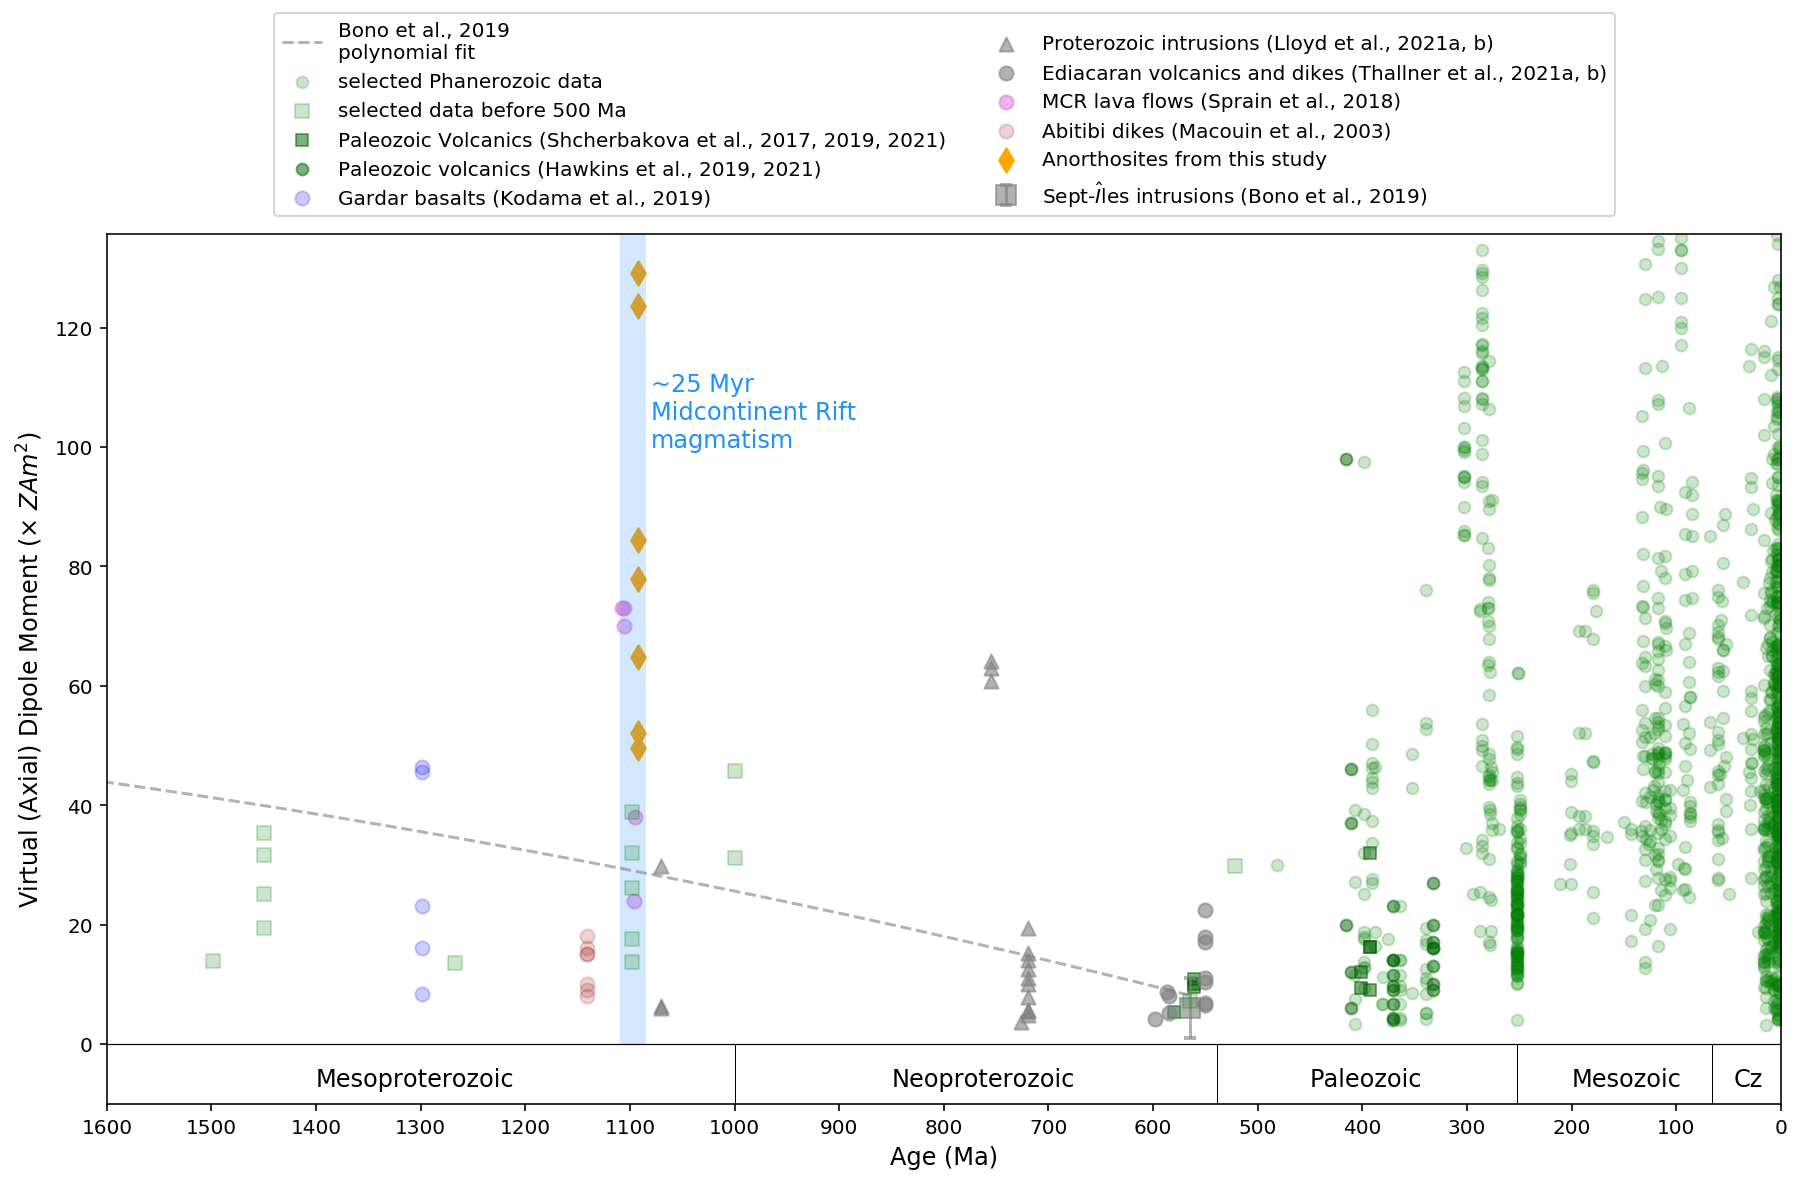

In [84]:
fig, ax = plt.subplots(figsize=(15, 8))

# Post Cambrian data
ax.scatter(PINT_post_500.AGE.tolist(), PINT_post_500['VDM+VADM'], 35, marker = 'o', color = 'green', alpha = 0.2, 
           label='selected Phanerozoic data')
# Precambrian data
ax.scatter(PINT_pre_500['AGE'].tolist(), PINT_pre_500['VDM'], 50, marker = 's', color = 'green', alpha = 0.2, 
           zorder = 100, label='selected data before 500 Ma')

# Shcherbakova 2017, 2019, 2021 data
ax.scatter(Shcherbakova2017a_data['age'].tolist() + Shcherbakova2019a_data['age'].tolist() + Shcherbakova2021a_data['age'].tolist(),
           Shcherbakova2017a_data['VDM'].tolist() + Shcherbakova2019a_data['VDM'].tolist() + Shcherbakova2021a_data['VDM'].tolist(), 35, marker = 's', 
           color = 'darkgreen', alpha = 0.5, label='Paleozoic Volcanics (Shcherbakova et al., 2017, 2019, 2021)')

# Hawkins 2019a, 2021a data
ax.scatter(Hawkins2019a_data['age'].tolist()+Hawkins2021a_data['age'].tolist(), 
           Hawkins2019a_data['VDM'].tolist()+Hawkins2021a_data['VDM'].tolist(), 
           35, marker = 'o', color = 'darkgreen', alpha = 0.5, label = 'Paleozoic volcanics (Hawkins et al., 2019, 2021)')

# Kodama 2019a data
ax.scatter(Kodama2019a_data['age'], Kodama2019a_data['VDM'], 50, marker = 'o', color = 'blue', alpha = 0.2, label='Gardar basalts (Kodama et al., 2019)')

# Bono 2019 single crystal data
ax.errorbar(Bono_2019_data.iloc[0]['Age'], Bono_2019_data.iloc[0]['VDM'], yerr=Bono_2019_data.iloc[0]['sigma'], 
            markersize = 10, color = 'grey', alpha = 0.6, fmt='s', capsize = 3, capthick=2, label='Sept-$\hat{I}$les intrusions (Bono et al., 2019)')

# Lloyd2021a Cryogenian data
ax.scatter(Lloyd2021a_data['age'], Lloyd2021a_data['VDM'].tolist(), 
           50, marker = '^', color = 'grey', alpha = 0.6, label='Proterozoic intrusions (Lloyd et al., 2021a, b)')

# Lloyd2021b Australia data
ax.scatter(Lloyd2021b_data['age'].tolist(), Lloyd2021b_data['VDM'].tolist(), 
           50, marker = '^', color = 'grey', alpha = 0.6)

# Thallner2021a Skinner Cove data
ax.scatter(Thallner2021a_data['age'], Thallner2021a_data['VDM'].tolist(), 
           50, marker = 'o', color = 'grey', alpha = 0.6, label='Ediacaran volcanics and dikes (Thallner et al., 2021a, b)')

# Thallner2021b Ediacaran Grenville dikes data
ax.scatter(Thallner2021b_data['age'], Thallner2021b_data['VDM'].tolist(), 
           50, marker = 'o', color = 'grey', alpha = 0.6)

# Sprain et al., 2018 data
ax.scatter(MCR_PINT_volc['AGE'],MCR_PINT_volc['VDM']*10, 50,
             color='orchid',marker ='o',
            label = 'MCR lava flows (Sprain et al., 2018)',alpha=0.5)

# Macouin et al., 2003a abitibi dikes
plt.scatter(MCR_PINT_Abitibi['AGE'],MCR_PINT_Abitibi['VDM']*10, 50,
             color='brown',marker ='o', 
            label = 'Abitibi dikes (Macouin et al., 2003)',alpha=0.2)

# this study
ax.scatter(MCR_PINT_BBC['AGE'],MCR_PINT_BBC['VDM']*10, s = 75,
             color='orange',marker ='d', 
            label = 'Anorthosites from this study',alpha=1)


ax.text(1080, 100, '~25 Myr\nMidcontinent Rift\nmagmatism', color = 'dodgerblue', alpha=1, fontdict={'fontsize':12})
ax.add_patch(
    patches.Rectangle(
        xy=(1085, 0),  # point of origin.
        width=25,
        height=250,
        linewidth=0,
        color='dodgerblue', 
        alpha = 0.2,
        fill=True
    )
)
# ax.text(1150, 225, 'Midcontinent Rift \n $\sim$25 myr', fontsize = 14, color='lightcoral')

# second order polynomial fits
ax.plot(new_x, fit_y, color = 'grey', alpha= 0.6, ls='--', label='Bono et al., 2019\npolynomial fit')

# set up timescale box
ax.plot([0,3600], [0,0], linewidth = 0.6, color = 'black')
ax.plot([66.0, 66.0], [-10, 0], linewidth = 0.5, color = 'black')
ax.plot([251.9, 251.9], [-10, 0], linewidth = 0.5, color = 'black')
ax.plot([538.8, 538.8], [-10, 0], linewidth = 0.5, color = 'black')
ax.plot([1000, 1000], [-10, 0], linewidth = 0.5, color = 'black')
ax.plot([2500, 2500], [-10, 0], linewidth = 0.5, color = 'black')

fontdict = {'fontsize': 12}
ax.text(45, -7, 'Cz',fontdict=fontdict)
ax.text(200, -7, 'Mesozoic',fontdict=fontdict)
ax.text(450, -7, 'Paleozoic',fontdict=fontdict)


ax.text(850, -7, 'Neoproterozoic',fontdict=fontdict)
ax.text(1400, -7, 'Mesoproterozoic',fontdict=fontdict)

# ax.text(770, 68, 'Mundine \nWell \ndikes', fontdict={'fontsize':12, 'color':'grey'})
# ax.text(710, 20, 'Franklin\nLIP', fontdict={'fontsize':12, 'color':'grey'})
# ax.text(1070, 15, 'Bangemall\nSills', fontdict={'fontsize':12, 'color':'grey'})

# ax.text(3000, -7, 'Archean')

ax.set_xticks(np.arange(-100, 1700, 100))
ax.set_xlim(0, 1600)
ax.set_ylim(-10, np.percentile(PINT_66Ma['VDM+VADM'].dropna(), [99]))
plt.gca().invert_xaxis()
plt.xlabel('Age (Ma)', fontsize = 12)
plt.ylabel(r'Virtual (Axial) Dipole Moment ($\times$ $ZAm^2$)', fontsize = 12)
plt.legend(loc=(0.1, 1.02), ncol=2)
plt.savefig('code_output/PINT_compilation.pdf', bbox_inches='tight')
plt.show()